# Energy Portfolio Optimization for Switzerland 2050

This notebook implements a comprehensive energy portfolio optimization framework with four main sections:

0. **External Data Overview** - Visualization of all input data (solar, wind, prices, etc.)
1. **Dispatch Simulation** - Full year hourly dispatch of energy production and storage
2. **Genetic Optimizer** - Multi-objective optimization using genetic algorithms
3. **Pareto Frontier Analysis** - 3D Pareto frontier identification and visualization

### Key Changes (v2.0):
- **Palm oil only**: Biooil storage removed; Palm oil is the only imported bio-fuel
- **Aviation fuel from Fuel Tank**: Synthetic fuel supplies aviation (23 TWh/year)
- **Dynamic pricing**: Palm oil prices from futures data (USD/ton → CHF/MWh)
- **Water inflow to lakes**: Precipitation-based inflow at 0.9 kWh/m³
- **EUR→CHF conversion**: Spot prices converted using daily exchange rates
- **LCOE from analysis file**: Pre-computed efficiency and costs with parallelism

---


In [73]:
# =============================================================================
# IMPORTS - Run this cell first
# =============================================================================

# Standard library
import os
import sys
import json
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

# Progress tracking
from tqdm.notebook import tqdm

# Interactive widgets
try:
    import ipywidgets as widgets
    from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, IntSlider
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("⚠️ ipywidgets not installed. Run: pip install ipywidgets")

# Suppress warnings
warnings.filterwarnings('ignore')

# =============================================================================
# RELOAD MODULES - Run this to reload all project modules without restarting kernel
# =============================================================================
import importlib

# Reload all project-specific modules
importlib.reload(sys.modules.get('config', importlib.import_module('config')))
importlib.reload(sys.modules.get('data_loader', importlib.import_module('data_loader')))
importlib.reload(sys.modules.get('ppu_framework', importlib.import_module('ppu_framework')))
importlib.reload(sys.modules.get('dispatch_engine', importlib.import_module('dispatch_engine')))
importlib.reload(sys.modules.get('optimization', importlib.import_module('optimization')))
importlib.reload(sys.modules.get('portfolio_metrics', importlib.import_module('portfolio_metrics')))
importlib.reload(sys.modules.get('risk_calculator', importlib.import_module('risk_calculator')))
importlib.reload(sys.modules.get('multi_objective_explorer', importlib.import_module('multi_objective_explorer')))
importlib.reload(sys.modules.get('pareto_frontier', importlib.import_module('pareto_frontier')))
importlib.reload(sys.modules.get('visualization', importlib.import_module('visualization')))
importlib.reload(sys.modules.get('frontier_research', importlib.import_module('frontier_research')))

# Re-import after reload
from config import Config, DEFAULT_CONFIG
from data_loader import load_all_data, CachedData
from ppu_framework import (
    load_all_ppu_data, Portfolio, create_ppu_dictionary,
    estimate_annual_production, check_energy_sovereignty
)
from dispatch_engine import (
    run_dispatch_simulation, initialize_storage_state,
    compute_scenario_cost
)
from optimization import (
    evaluate_portfolio_full_year, Individual,
    run_genetic_algorithm, FullYearResults
)
from portfolio_metrics import (
    PortfolioMetrics3D, calculate_portfolio_metrics_3d
)
from risk_calculator import RiskCalculator
from multi_objective_explorer import (
    MultiObjectiveGA, ObjectiveConfig,
    explore_and_find_frontier, continue_exploration_3d_frontier
)
from pareto_frontier import (
    find_and_plot_efficiency_frontier,
    load_frontier_from_csv,
    plot_efficiency_frontier,
    extract_pareto_frontier_from_df
)
from visualization import (
    plot_fitness_evolution, plot_portfolio_composition,
    plot_dispatch_scenario, create_optimization_dashboard,
    plot_demand_volatility, plot_spot_price_volatility,
    plot_energy_balance_distribution, plot_full_year_overview,
    plot_full_year_storage, plot_full_year_production_by_source
)
from frontier_research import (
    run_frontier_research, FrontierResearchConfig, FrontierResearchResults
)


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Create output directories
os.makedirs('data/result_plots', exist_ok=True)


print("✅ All imports successful!")
print(f"   Config loaded: {type(DEFAULT_CONFIG).__name__}")
print(f"   Widgets available: {HAS_WIDGETS}")
print("   🔄 Modules reloaded - changes will take effect immediately")


✅ All imports successful!
   Config loaded: Config
   Widgets available: True
   🔄 Modules reloaded - changes will take effect immediately


In [74]:
# =============================================================================
# LOAD DATA - Run after imports
# =============================================================================

print("Loading system data...")
config = DEFAULT_CONFIG
cached_data = load_all_data(config=config, force_reload=True)

# Load PPU definitions (returns tuple: cost_df, constructs_df, ppu_definitions)
cost_df, ppu_df, ppu_definitions = load_all_ppu_data(config=config)
risk_calc = RiskCalculator(config=config)

print(f"\n✅ Data loaded successfully!")
print(f"   Demand data: {len(cached_data.get_demand())} hours")
print(f"   Spot prices: {len(cached_data.get_spot_prices())} hours (EUR→CHF converted)")
print(f"   Palm oil prices: {len(cached_data.palm_oil_chf_mwh)} days")
print(f"   Water inflow: {len(cached_data.water_inflow_mwh)} hours ({cached_data.water_inflow_mwh.sum()/1e6:.2f} TWh/year)")
print(f"   Exchange rates: EUR/CHF ({len(cached_data.eur_chf_daily)} days), USD/CHF ({len(cached_data.usd_chf_daily)} days)")
print(f"   PPU types: {len(ppu_definitions)} defined (LCOE from analysis file)")


Loading system data...
Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete!

✅ Data loaded successfully!
   Demand data: 8784 hours
   Spot prices: 8784 hours (EUR→CHF converted)
   Palm oil prices: 366 days
   Water inflow: 8784 hours (42.74 TWh/year)
   Exchange rates: EUR/CHF (366 days), USD/CHF (366 days)
   PPU types: 26 defined (LCOE from analysis file)


---

# Section 0: External Data Overview

This section provides an overview of all external input data used in the energy portfolio optimization:

1. **Solar Irradiance** - Hourly solar irradiance across ~1150 Swiss locations
2. **Wind Speed** - Hourly wind speeds across ~1150 Swiss locations  
3. **Run of River** - Monthly hydropower production from run-of-river plants
4. **Electricity Spot Price** - Hourly Swiss electricity spot prices (converted EUR→CHF)
5. **Palm Oil Prices** - Daily palm oil futures prices (USD/ton → CHF/MWh)
6. **Water Inflow to Lakes** - Hourly precipitation-based water inflow (m³ → MWh)
7. **Currency Exchange Rates** - EUR/CHF and USD/CHF daily rates

### Data Sources:
- **Solar/Wind**: Open-Meteo Archive API (ERA5 reanalysis, 0.1° × 0.1° grid)
- **Spot Prices**: ENTSO-E (Swiss day-ahead prices in EUR/MWh)
- **Palm Oil**: REA Holdings share prices (proxy for palm oil futures)
- **Water Inflow**: Open-Meteo precipitation data with 0.9 kWh/m³ conversion factor
- **Exchange Rates**: Dukascopy (USD/CHF) and ECB reference rates (EUR/CHF)


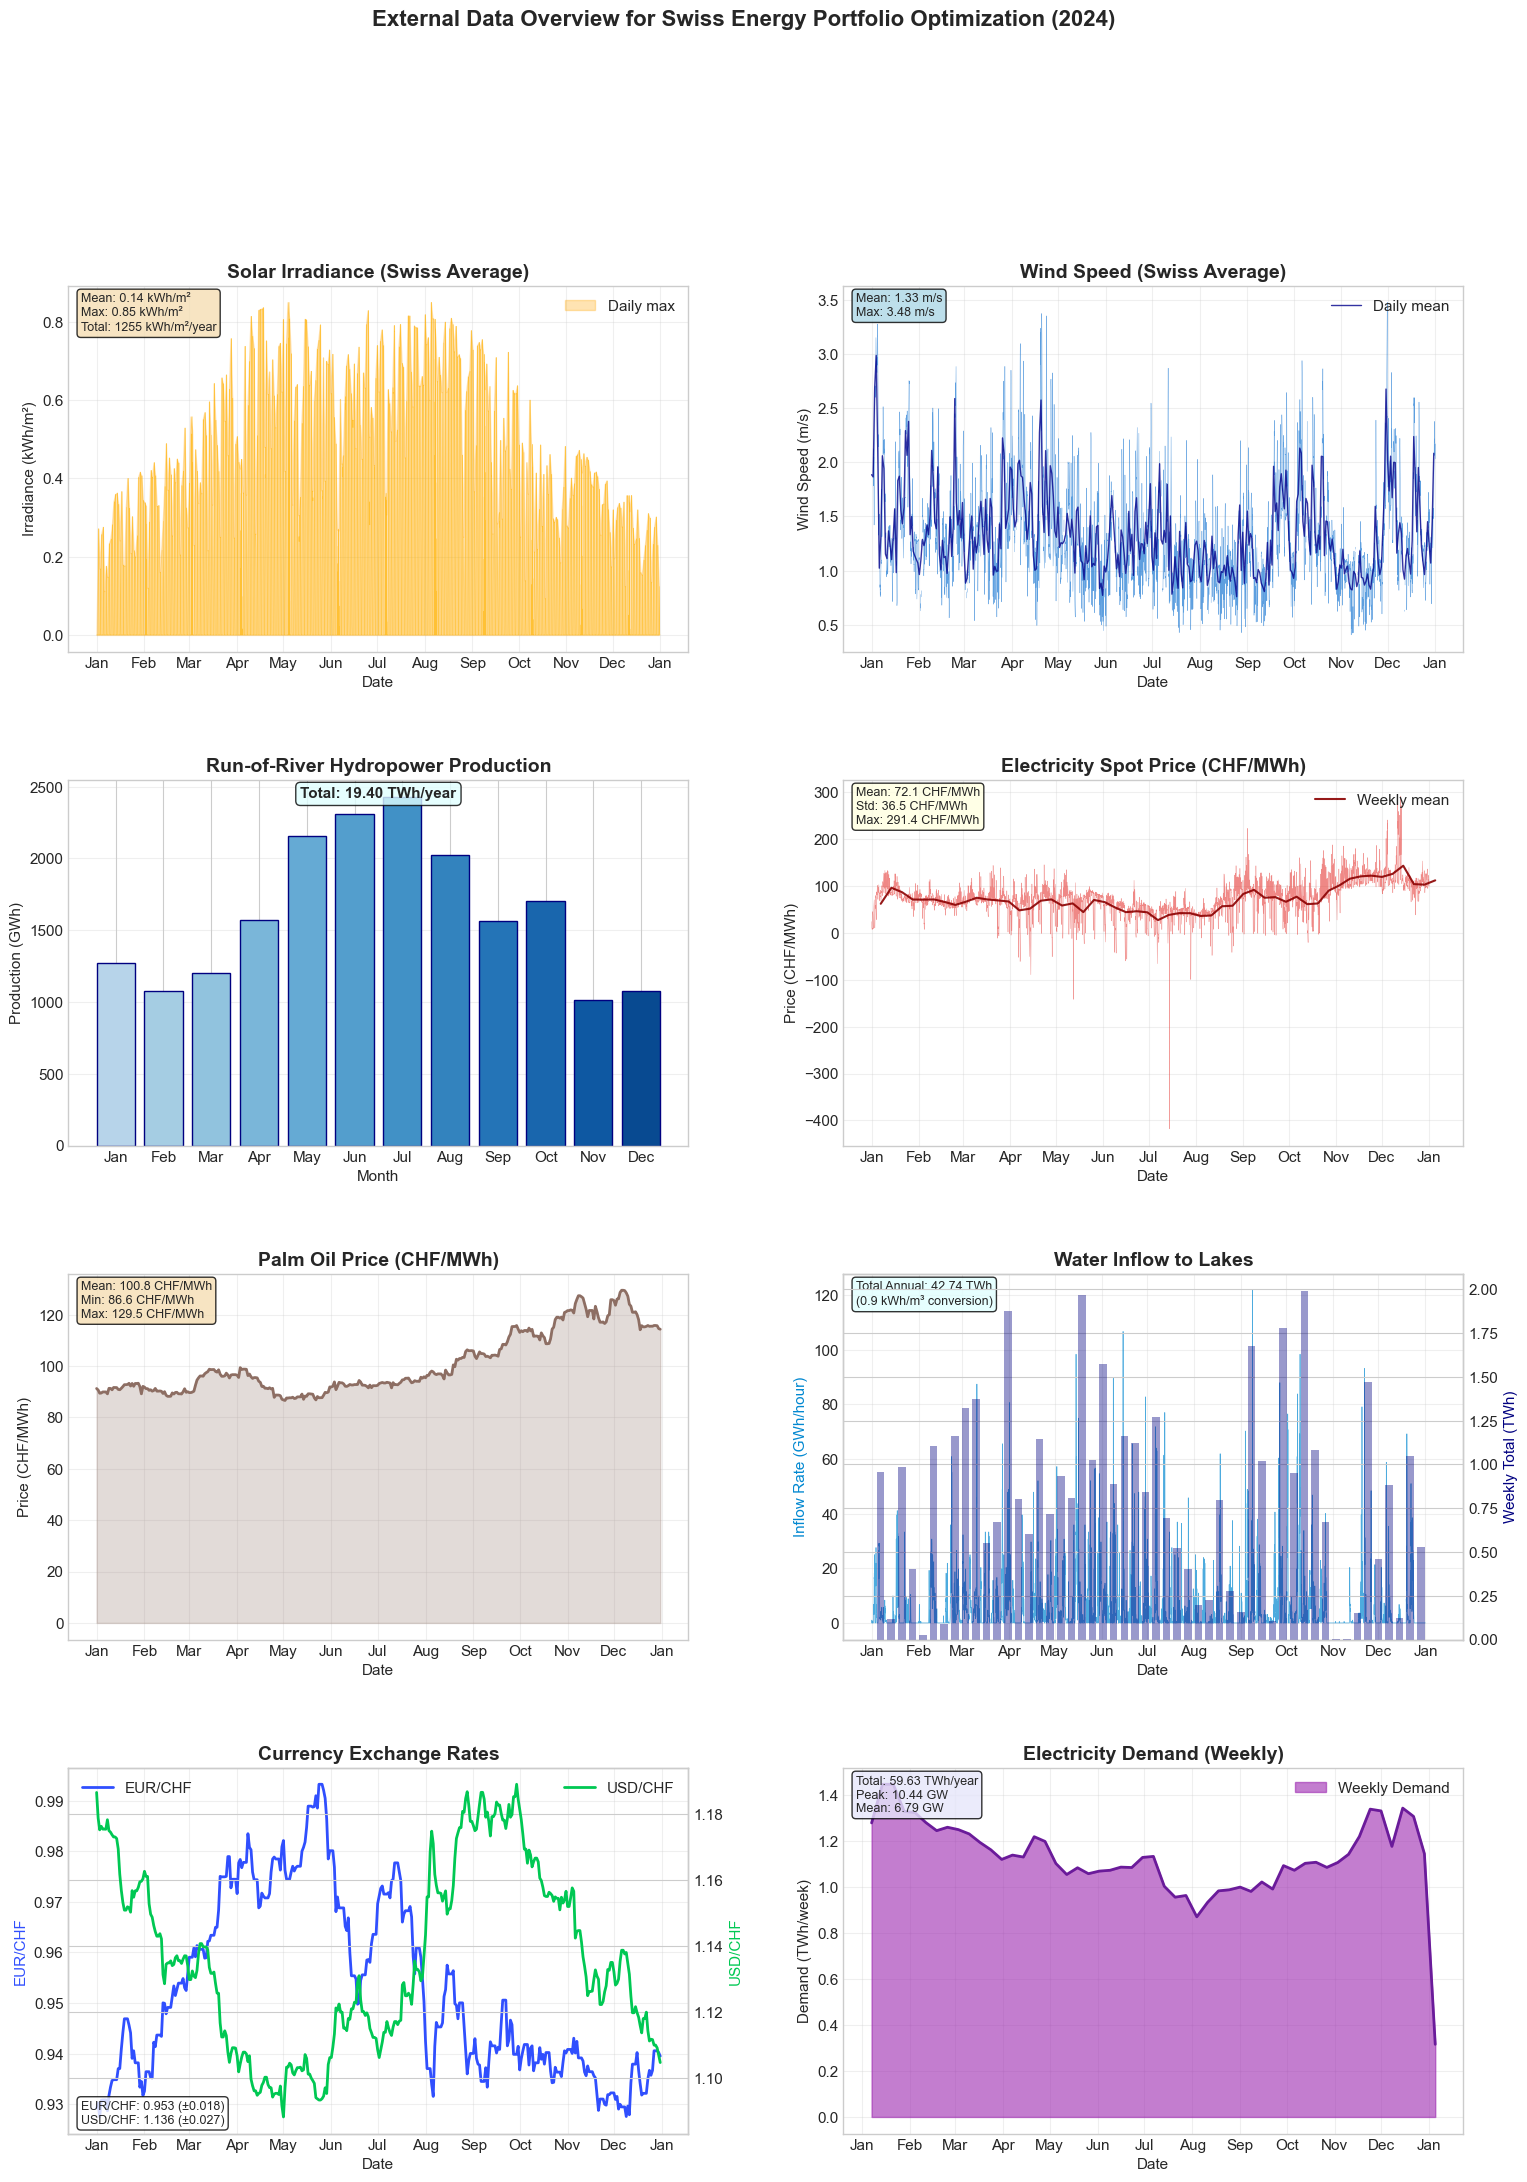


✅ External data overview saved to: data/result_plots/external_data_overview.png


In [75]:
# =============================================================================
# SECTION 0: EXTERNAL DATA OVERVIEW
# =============================================================================
# This cell generates overview plots for all external input data

# Create time indices
n_hours = len(cached_data.get_demand())
hours = pd.date_range('2024-01-01', periods=n_hours, freq='h')
days = pd.date_range('2024-01-01', periods=366, freq='D')

# Get data
solar_data = cached_data.get_solar_incidence(copy=False)
wind_data = cached_data.get_wind_incidence(copy=False)
spot_prices = cached_data.get_spot_prices(copy=False)
demand = cached_data.get_demand(copy=False)
water_inflow = cached_data.get_water_inflow(copy=False)
palm_oil_prices = cached_data.get_palm_oil_prices_daily(copy=False)
eur_chf = cached_data.eur_chf_daily
usd_chf = cached_data.usd_chf_daily
ror_production = cached_data.ror_production  # Monthly RoR

# Calculate spatial averages for solar and wind
solar_avg = np.nanmean(solar_data, axis=1)  # Average across locations per hour
wind_avg = np.nanmean(wind_data, axis=1)    # Average across locations per hour

# Create figure with subplots
fig = plt.figure(figsize=(18, 24))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.25)

# -----------------------------------------------------------------------------
# Plot 1: Solar Irradiance (kWh/m²)
# -----------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(hours[:len(solar_avg)], solar_avg, color='#FFB300', alpha=0.7, linewidth=0.3)
# Add daily max envelope
daily_max = pd.Series(solar_avg[:len(hours)], index=hours[:len(solar_avg)]).resample('D').max()
ax1.fill_between(daily_max.index, daily_max.values, alpha=0.3, color='orange', label='Daily max')
ax1.set_title('Solar Irradiance (Swiss Average)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Irradiance (kWh/m²)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.nanmean(solar_avg):.2f} kWh/m²\nMax: {np.nanmax(solar_avg):.2f} kWh/m²\nTotal: {np.nansum(solar_avg):.0f} kWh/m²/year"
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 2: Wind Speed (m/s)
# -----------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(hours[:len(wind_avg)], wind_avg, color='#1976D2', alpha=0.7, linewidth=0.3)
# Add daily mean
daily_mean_wind = pd.Series(wind_avg[:len(hours)], index=hours[:len(wind_avg)]).resample('D').mean()
ax2.plot(daily_mean_wind.index, daily_mean_wind.values, color='darkblue', alpha=0.8, linewidth=1, label='Daily mean')
ax2.set_title('Wind Speed (Swiss Average)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Wind Speed (m/s)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.nanmean(wind_avg):.2f} m/s\nMax: {np.nanmax(wind_avg):.2f} m/s"
ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 3: Run of River (Monthly)
# -----------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
from matplotlib import cm
colors_ror = cm.get_cmap('Blues')(np.linspace(0.3, 0.9, 12))
bars = ax3.bar(months, ror_production[:12], color=colors_ror, edgecolor='navy', linewidth=1)
ax3.set_title('Run-of-River Hydropower Production', fontsize=14, fontweight='bold')
ax3.set_xlabel('Month')
ax3.set_ylabel('Production (GWh)')
ax3.grid(True, alpha=0.3, axis='y')

# Add total annotation
total_ror = np.sum(ror_production[:12])
ax3.annotate(f'Total: {total_ror/1000:.2f} TWh/year', xy=(0.5, 0.95), xycoords='axes fraction',
             fontsize=11, ha='center', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 4: Electricity Spot Price (CHF/MWh)
# -----------------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(hours[:len(spot_prices)], spot_prices, color='#E53935', alpha=0.6, linewidth=0.3)
# Add weekly mean
weekly_mean = pd.Series(spot_prices[:len(hours)], index=hours[:len(spot_prices)]).resample('W').mean()
ax4.plot(weekly_mean.index, weekly_mean.values, color='darkred', alpha=0.9, linewidth=1.5, label='Weekly mean')
ax4.set_title('Electricity Spot Price (CHF/MWh)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Price (CHF/MWh)')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax4.xaxis.set_major_locator(mdates.MonthLocator())
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.mean(spot_prices):.1f} CHF/MWh\nStd: {np.std(spot_prices):.1f} CHF/MWh\nMax: {np.max(spot_prices):.1f} CHF/MWh"
ax4.text(0.02, 0.98, stats_text, transform=ax4.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 5: Palm Oil Price (CHF/MWh)
# -----------------------------------------------------------------------------
ax5 = fig.add_subplot(gs[2, 0])
days_palm = days[:len(palm_oil_prices)]
ax5.plot(days_palm, palm_oil_prices, color='#8D6E63', linewidth=2, marker='', label='Palm Oil (CHF/MWh)')
ax5.fill_between(days_palm, palm_oil_prices, alpha=0.3, color='#A1887F')
ax5.set_title('Palm Oil Price (CHF/MWh)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Price (CHF/MWh)')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
ax5.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.mean(palm_oil_prices):.1f} CHF/MWh\nMin: {np.min(palm_oil_prices):.1f} CHF/MWh\nMax: {np.max(palm_oil_prices):.1f} CHF/MWh"
ax5.text(0.02, 0.98, stats_text, transform=ax5.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 6: Water Inflow to Lakes (MWh/hour)
# -----------------------------------------------------------------------------
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(hours[:len(water_inflow)], water_inflow/1000, color='#0288D1', alpha=0.7, linewidth=0.5)  # Convert to GWh
# Add weekly sum
weekly_sum = pd.Series(water_inflow[:len(hours)], index=hours[:len(water_inflow)]).resample('W').sum()
ax6_twin = ax6.twinx()
ax6_twin.bar(weekly_sum.index, weekly_sum.values/1e6, width=5, alpha=0.4, color='navy', label='Weekly total (TWh)')
ax6.set_title('Water Inflow to Lakes', fontsize=14, fontweight='bold')
ax6.set_xlabel('Date')
ax6.set_ylabel('Inflow Rate (GWh/hour)', color='#0288D1')
ax6_twin.set_ylabel('Weekly Total (TWh)', color='navy')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax6.xaxis.set_major_locator(mdates.MonthLocator())
ax6.grid(True, alpha=0.3)

# Stats box
total_inflow_twh = np.sum(water_inflow) / 1e6
stats_text = f"Total Annual: {total_inflow_twh:.2f} TWh\n(0.9 kWh/m³ conversion)"
ax6.text(0.02, 0.98, stats_text, transform=ax6.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 7: Currency Exchange Rates
# -----------------------------------------------------------------------------
ax7 = fig.add_subplot(gs[3, 0])
ax7.plot(days[:len(eur_chf)], eur_chf, color='#304FFE', linewidth=2, label='EUR/CHF')
ax7_twin = ax7.twinx()
ax7_twin.plot(days[:len(usd_chf)], usd_chf, color='#00C853', linewidth=2, label='USD/CHF')
ax7.set_title('Currency Exchange Rates', fontsize=14, fontweight='bold')
ax7.set_xlabel('Date')
ax7.set_ylabel('EUR/CHF', color='#304FFE')
ax7_twin.set_ylabel('USD/CHF', color='#00C853')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax7.xaxis.set_major_locator(mdates.MonthLocator())
ax7.legend(loc='upper left')
ax7_twin.legend(loc='upper right')
ax7.grid(True, alpha=0.3)

# Stats box
stats_text = f"EUR/CHF: {np.mean(eur_chf):.3f} (±{np.std(eur_chf):.3f})\nUSD/CHF: {np.mean(usd_chf):.3f} (±{np.std(usd_chf):.3f})"
ax7.text(0.02, 0.02, stats_text, transform=ax7.transAxes, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 8: Demand vs Supply Overview
# -----------------------------------------------------------------------------
ax8 = fig.add_subplot(gs[3, 1])
demand_weekly = pd.Series(demand[:len(hours)], index=hours[:len(demand)]).resample('W').sum() / 1e6  # TWh
ax8.fill_between(demand_weekly.index, demand_weekly.values, alpha=0.6, color='#9C27B0', label='Weekly Demand')
ax8.plot(demand_weekly.index, demand_weekly.values, color='#6A1B9A', linewidth=2)
ax8.set_title('Electricity Demand (Weekly)', fontsize=14, fontweight='bold')
ax8.set_xlabel('Date')
ax8.set_ylabel('Demand (TWh/week)')
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax8.xaxis.set_major_locator(mdates.MonthLocator())
ax8.legend(loc='upper right')
ax8.grid(True, alpha=0.3)

# Stats box
total_demand_twh = np.sum(demand) / 1e6
stats_text = f"Total: {total_demand_twh:.2f} TWh/year\nPeak: {np.max(demand)/1000:.2f} GW\nMean: {np.mean(demand)/1000:.2f} GW"
ax8.text(0.02, 0.98, stats_text, transform=ax8.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8))

# Add overall title
fig.suptitle('External Data Overview for Swiss Energy Portfolio Optimization (2024)', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('data/result_plots/external_data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ External data overview saved to: data/result_plots/external_data_overview.png")


---

# Section 1: Dispatch Simulation

This section runs a full year (8760 hours) dispatch simulation for a given portfolio.

## Renewable Production Model: DISTRIBUTED DEPLOYMENT

Unlike concentrated deployment (all capacity at best locations), this model simulates **realistic distributed deployment**:

### Solar PV
- **Each PPU adds 1,000 m² to EVERY location** (~1,150 locations)
- Total area per PPU: 1,000 m² × 1,150 = **1,150,000 m²** (~1.15 km²)
- Simulates: rooftop solar spread across all of Switzerland

### Wind (Onshore & Offshore)
- **Each PPU adds 1 turbine to EVERY location** (~1,150 locations)
- Total turbines per PPU: 1 × 1,150 = **1,150 turbines**
- Onshore: 3 MW turbines | Offshore: 5 MW turbines
- Simulates: distributed wind farms across all regions

### Grid Resolution
- **0.1° × 0.1°** grid (~11 km × 8 km cells)
- **~1,150 locations** covering Switzerland
- Each cell area: ~84 km²

## Energy System Constraints
- **Annual Electricity Demand:** 59.63 TWh (2050 projection)
- **Aviation Fuel Requirement:** 23 TWh/year synthetic fuel from Fuel Tank (produced by SYN_FT/SYN_CRACK)

## Storage Constraints
| Storage | Base Capacity | Max Cap | RT Efficiency | Notes |
|---------|--------------|---------|---------------|-------|
| Lake | 8.87 TWh (fixed) | - | 77.4% | Physical 2 GW power cap + water inflow |
| H2 UG 200bar | Scales | **50 TWh** | 30% | |
| Liquid H2 | Scales | **50 TWh** | 35% | |
| CH4 200bar | Scales | **50 TWh** | 39% | |
| Ammonia | Scales | **50 TWh** | 29.25% | |
| Fuel Tank | Scales | **25 TWh** | 35% | Also supplies aviation fuel |
| Biogas | Scales | **25 TWh** | 49% | |
| Palm oil | 500 GWh | - | 30% | Ghost PPU import (only bio-fuel) |

## Utility-Based Dispatch Logic

All storages **self-regulate** around their **target SoC (60%)** using the disposition index:

$$d = \tanh\left(\frac{\text{SoC} - \text{target}}{\text{max\_excursion}}\right)$$

| SoC | Disposition | Behavior |
|-----|-------------|----------|
| 0% | d = -1 | **Wants to charge** |
| 60% | d = 0 | Neutral (at target) |
| 100% | d = +1 | **Wants to discharge** |

### Surplus Distribution (Renewable > Demand)
- **Proportional** to charge willingness × efficiency
- `charge_willingness = max(0, 0.5 - d)` → storages below target get MORE
- No fixed priority order - all storages compete proportionally

### Deficit Coverage (Renewable < Demand)  
- **Cost merit order** with disposition penalty
- `effective_cost = base_cost + penalty(d)` → low SoC storages are "expensive"
- Cheapest sources dispatched first, protecting low storages

### Ghost PPU Mechanism (Palm oil only)
- Palm oil is the **only imported bio-fuel** (Biooil removed)
- Participates in **proportional** surplus distribution (not fixed %)
- Its share is sold on spot market → revenue buys palm oil at dynamic price
- Price from REA Holdings futures (USD/ton → CHF/MWh via exchange rates)
- Storage self-regulates like all others around 60% target SoC

---


In [76]:
# =============================================================================
# SECTION 1.1: Define Test Portfolio
# =============================================================================

# Example portfolio for testing (can be modified)
# NOTE: BIO_OIL_ICE removed - Palm oil is the only imported bio-fuel
test_portfolio = {
    # Renewable (incidence-based)
    'PV': 300, 'WD_ON': 10, 'WD_OFF': 10, 'HYD_R': 50, 'BIO_WOOD': 100,
    # Storage input
    'PHS': 300, 'H2_G': 100, 'H2_GL': 100, 'H2_L': 200,
    'SYN_FT': 100, 'SYN_CRACK': 200, 'SYN_METH': 200, 'NH3_FULL': 150, 'CH4_BIO': 100,  # Increased SYN_FT/CRACK for aviation
    # Storage extraction (dispatchable)
    'HYD_S': 300, 'THERM': 250, 'H2P_G': 100, 'H2P_L': 150,  # Increased THERM for aviation fuel
    'THERM_CH4': 300, 'NH3_P': 100, 'IMP_BIOG': 100, 'PALM_ICE': 150,  # Only PALM_ICE (no BIO_OIL_ICE)
}

print("Test Portfolio Configuration:")
print("=" * 60)
total_units = sum(test_portfolio.values())
print(f"Total PPU units: {total_units}")
renewable = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
storage_in = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_CRACK', 'SYN_METH', 'NH3_FULL', 'CH4_BIO']
storage_out = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'THERM_CH4', 'NH3_P', 'IMP_BIOG', 'PALM_ICE']  # No BIO_OIL_ICE
print(f"  Renewable: {sum(test_portfolio.get(p, 0) for p in renewable)} units")
print(f"  Storage Input: {sum(test_portfolio.get(p, 0) for p in storage_in)} units")
print(f"  Storage Extraction: {sum(test_portfolio.get(p, 0) for p in storage_out)} units")


Test Portfolio Configuration:
Total PPU units: 3370
  Renewable: 470 units
  Storage Input: 1450 units
  Storage Extraction: 1450 units


In [77]:
# =============================================================================
# SECTION 1.2: Run Full Year Dispatch Simulation
# =============================================================================

print("Running full year dispatch simulation (8760 hours)...")
print("=" * 60)

# Create Portfolio and Individual objects from dictionary
from ppu_framework import Portfolio
from optimization import Individual

test_individual = Individual(
    portfolio=Portfolio(ppu_counts=test_portfolio)
)

# Run full year evaluation
full_year_results = evaluate_portfolio_full_year(
    individual=test_individual,
    config=config,
    verbose=True
)

print("\n" + "=" * 60)
print("DISPATCH SIMULATION RESULTS")
print("=" * 60)

# Energy Balance
total_demand = np.sum(full_year_results.demand) / 1e6
total_production = np.sum(full_year_results.total_production) / 1e6
total_renewable = np.sum(full_year_results.renewable_production) / 1e6
total_bought = np.sum(full_year_results.spot_bought) / 1e6
total_sold = np.sum(full_year_results.spot_sold) / 1e6

print(f"\n📊 Energy Balance:")
print(f"   Total Demand:      {total_demand:>10.2f} TWh")
print(f"   Total Production:  {total_production:>10.2f} TWh")
print(f"   Renewable Only:    {total_renewable:>10.2f} TWh ({100*total_renewable/total_demand:.1f}%)")
print(f"   Spot Bought:       {total_bought:>10.2f} TWh")
print(f"   Spot Sold:         {total_sold:>10.2f} TWh")

# Renewable vs Demand (before storage)
ren = full_year_results.renewable_production
dem = full_year_results.demand
print(f"\n🔍 Renewable vs Demand (before storage):")
print(f"   Gap to fill:       {(np.sum(dem)-np.sum(ren))/1e6:>10.2f} TWh")
print(f"   Hours surplus:     {np.sum(ren > dem):>10} ({100*np.sum(ren>dem)/len(dem):.1f}%)")
print(f"   Hours deficit:     {np.sum(ren < dem):>10} ({100*np.sum(ren<dem)/len(dem):.1f}%)")

# Aviation Fuel (from Fuel Tank - synthetic fuel)
if hasattr(full_year_results, 'aviation_fuel_consumed_mwh'):
    consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
    shortfall = full_year_results.aviation_fuel_shortfall_mwh / 1e6 if hasattr(full_year_results, 'aviation_fuel_shortfall_mwh') else 0
    production_cost = full_year_results.aviation_fuel_import_cost_chf / 1e9 if hasattr(full_year_results, 'aviation_fuel_import_cost_chf') else 0
    print(f"\n✈️  Aviation Fuel (from Fuel Tank - synthetic):")
    print(f"   Required:          {23.0:>10.2f} TWh/year")
    print(f"   Consumed:          {consumed:>10.2f} TWh")
    print(f"   Shortfall:         {shortfall:>10.2f} TWh")
    print(f"   Production Cost:   {production_cost:>10.2f} B CHF")
    print(f"   Constraint Met:    {'✅ Yes' if full_year_results.aviation_fuel_constraint_met else '❌ No'}")

print("\n" + "=" * 60)


Running full year dispatch simulation (8760 hours)...
FULL YEAR EVALUATION

Loading full year data...
Loading PPU definitions...
Simulating 8784 hours (366 days)...

FULL YEAR RESULTS
Total Demand:     59.6 TWh
Total Production: 115.6 TWh
Coverage Ratio:   193.8%

Spot Market:
  Bought: 0.00 TWh
  Sold:   52.39 TWh
  Net Cost: -2,578.4 M CHF

Deficit Analysis:
  Hours in deficit: 0 (0.0%)
  Peak deficit: 0 MW

Aviation Fuel (from Fuel Tank - Synthetic):
  Required: 23.0 TWh/year
  Consumed: 17.34 TWh (75.4%)
  Shortfall: 5.72 TWh
  Production Cost: 1,040.4 M CHF
  Constraint Met: ❌ NO
  ⚠️  2470 hours with aviation fuel shortfall

Final Storage Constraint (±5% of initial SoC):
  Constraint Met: ❌ NO
  Total Penalty: 537,965,169
  ⚠️  Lake: initial=60.00% → final=96.66% (deviation: 36.66%, max allowed: 3.00%)
  ⚠️  Fuel Tank: initial=59.98% → final=0.00% (deviation: 59.98%, max allowed: 3.00%)
  ⚠️  H2 UG 200bar: initial=60.00% → final=43.01% (deviation: 16.99%, max allowed: 3.00%)
  ⚠️

In [78]:
# =============================================================================
# SECTION 1.2b: Incidence vs Demand Analysis (Before Storage)
# =============================================================================

print("=" * 70)
print("INCIDENCE vs DEMAND ANALYSIS (Before Storage Operations)")
print("=" * 70)

# Get hourly data
ren = full_year_results.renewable_production  # Incidence-based only
dem = full_year_results.demand
balance = ren - dem  # Positive = surplus, Negative = deficit

# Hourly statistics
surplus_hours = balance > 0
deficit_hours = balance < 0
balanced_hours = balance == 0

surplus_total = np.sum(balance[surplus_hours]) / 1e6  # TWh
deficit_total = -np.sum(balance[deficit_hours]) / 1e6  # TWh (positive value)

print(f"\n📊 HOURLY BREAKDOWN:")
print(f"   Hours with SURPLUS (ren > dem):  {np.sum(surplus_hours):>6} ({100*np.mean(surplus_hours):>5.1f}%)")
print(f"   Hours with DEFICIT (ren < dem):  {np.sum(deficit_hours):>6} ({100*np.mean(deficit_hours):>5.1f}%)")
print(f"   Hours balanced:                  {np.sum(balanced_hours):>6} ({100*np.mean(balanced_hours):>5.1f}%)")

print(f"\n⚡ ENERGY VOLUMES:")
print(f"   Total Incidence (Renewable):     {np.sum(ren)/1e6:>8.2f} TWh")
print(f"   Total Demand:                    {np.sum(dem)/1e6:>8.2f} TWh")
print(f"   -------------------------------------------")
print(f"   Net Gap (Demand - Incidence):    {(np.sum(dem)-np.sum(ren))/1e6:>8.2f} TWh")

print(f"\n🔋 WHAT STORAGE/DISPATCH MUST DO:")
print(f"   Energy from surplus hours:       {surplus_total:>8.2f} TWh (storable)")
print(f"   Energy needed in deficit hours:  {deficit_total:>8.2f} TWh (from storage/dispatch)")

# Peak analysis
peak_surplus = np.max(balance) / 1e3 if np.any(surplus_hours) else 0  # GW
peak_deficit = -np.min(balance) / 1e3 if np.any(deficit_hours) else 0  # GW
mean_deficit = -np.mean(balance[deficit_hours]) / 1e3 if np.any(deficit_hours) else 0  # GW

print(f"\n📈 PEAK ANALYSIS:")
print(f"   Peak Surplus Power:              {peak_surplus:>8.2f} GW")
print(f"   Peak Deficit Power:              {peak_deficit:>8.2f} GW")
print(f"   Mean Deficit (during def hrs):   {mean_deficit:>8.2f} GW")

# Monthly breakdown
print(f"\n📅 MONTHLY BREAKDOWN:")
print("-" * 70)
print(f"{'Month':<10} {'Incidence':<12} {'Demand':<12} {'Balance':<12} {'Status':<15}")
print("-" * 70)

# Assume 2024 (leap year) data
days_per_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

start_hour = 0
for month_idx, (days, name) in enumerate(zip(days_per_month, month_names)):
    end_hour = start_hour + days * 24
    if end_hour > len(dem):
        end_hour = len(dem)
    
    month_ren = np.sum(ren[start_hour:end_hour]) / 1e6
    month_dem = np.sum(dem[start_hour:end_hour]) / 1e6
    month_bal = month_ren - month_dem
    status = "✅ SURPLUS" if month_bal > 0 else "⚠️  DEFICIT"
    
    print(f"{name:<10} {month_ren:>10.2f}  {month_dem:>10.2f}  {month_bal:>+10.2f}  {status}")
    start_hour = end_hour

print("-" * 70)
print(f"{'TOTAL':<10} {np.sum(ren)/1e6:>10.2f}  {np.sum(dem)/1e6:>10.2f}  {(np.sum(ren)-np.sum(dem))/1e6:>+10.2f} TWh")
print("=" * 70)


INCIDENCE vs DEMAND ANALYSIS (Before Storage Operations)

📊 HOURLY BREAKDOWN:
   Hours with SURPLUS (ren > dem):    3288 ( 37.4%)
   Hours with DEFICIT (ren < dem):    5496 ( 62.6%)
   Hours balanced:                       0 (  0.0%)

⚡ ENERGY VOLUMES:
   Total Incidence (Renewable):        82.58 TWh
   Total Demand:                       59.63 TWh
   -------------------------------------------
   Net Gap (Demand - Incidence):      -22.95 TWh

🔋 WHAT STORAGE/DISPATCH MUST DO:
   Energy from surplus hours:          55.95 TWh (storable)
   Energy needed in deficit hours:     33.00 TWh (from storage/dispatch)

📈 PEAK ANALYSIS:
   Peak Surplus Power:                 50.58 GW
   Peak Deficit Power:                  9.65 GW
   Mean Deficit (during def hrs):       6.00 GW

📅 MONTHLY BREAKDOWN:
----------------------------------------------------------------------
Month      Incidence    Demand       Balance      Status         
-----------------------------------------------------------------

Saved: data/result_plots/incidence_vs_demand_analysis.png


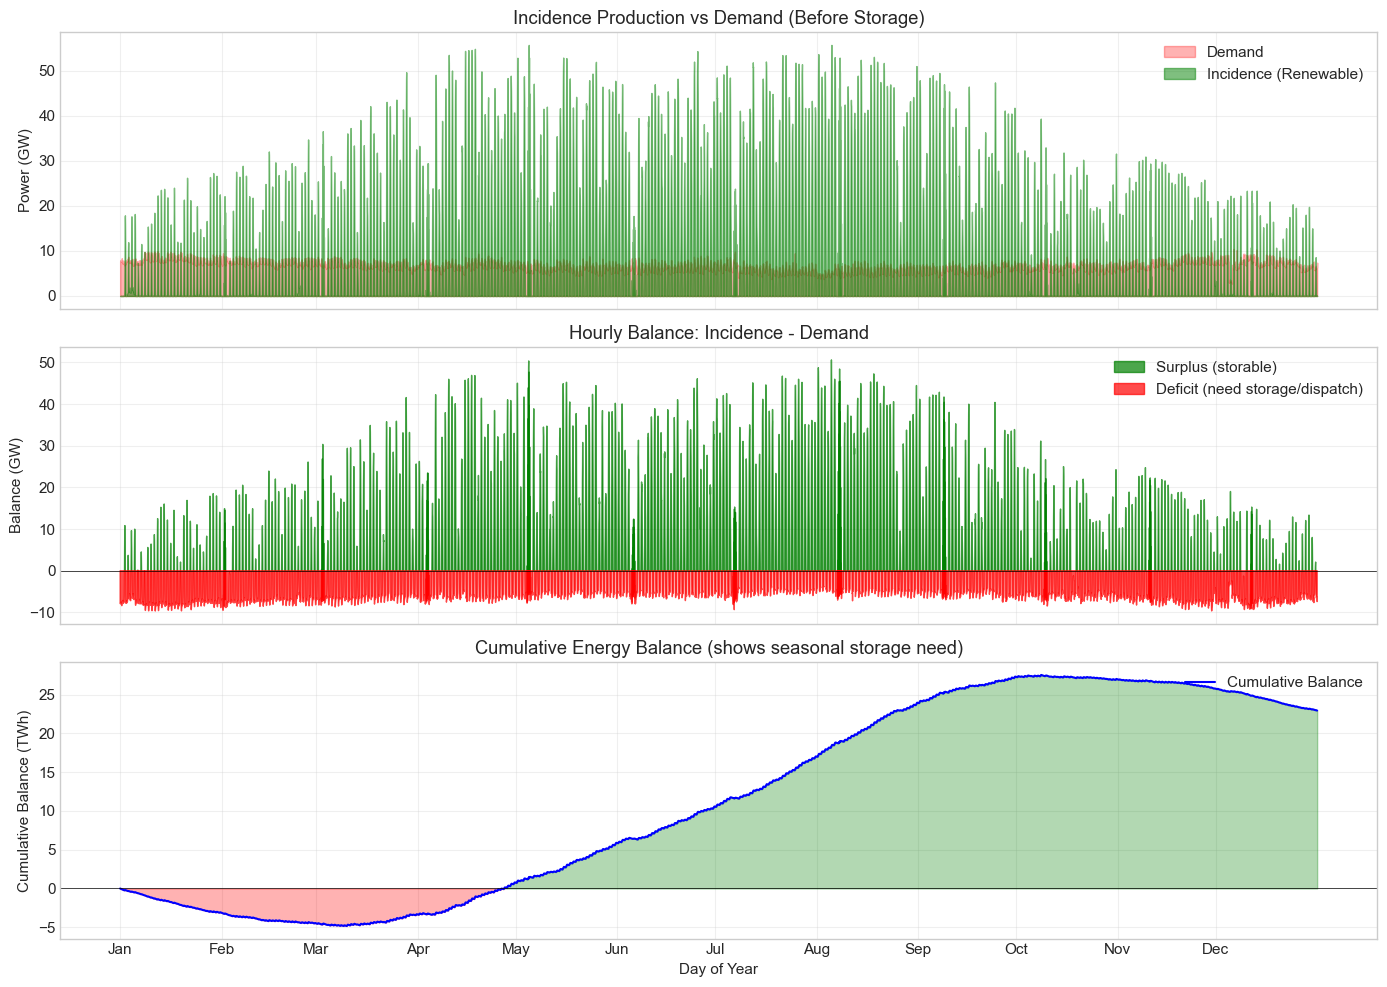


KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.
- Deepest negative point = minimum seasonal storage needed
- In this portfolio: 4.8 TWh seasonal storage required


In [79]:
# =============================================================================
# SECTION 1.2c: Incidence vs Demand Visualization
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Create time axis (days of year)
hours = np.arange(len(dem))
days = hours / 24

# Plot 1: Incidence vs Demand
ax1 = axes[0]
ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
ax1.set_ylabel('Power (GW)')
ax1.set_title('Incidence Production vs Demand (Before Storage)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Balance (Surplus/Deficit)
ax2 = axes[1]
balance_gw = balance / 1e3
ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                  label='Surplus (storable)', color='green', interpolate=True)
ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                  label='Deficit (need storage/dispatch)', color='red', interpolate=True)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Balance (GW)')
ax2.set_title('Hourly Balance: Incidence - Demand')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative Energy Balance
ax3 = axes[2]
cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                  alpha=0.3, color='green')
ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                  alpha=0.3, color='red')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Day of Year')
ax3.set_ylabel('Cumulative Balance (TWh)')
ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Add month labels
month_starts = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax3.set_xticks(month_starts)
ax3.set_xticklabels(month_labels)

plt.tight_layout()
plt.savefig('data/result_plots/incidence_vs_demand_analysis.png', dpi=150, bbox_inches='tight')
print("Saved: data/result_plots/incidence_vs_demand_analysis.png")
plt.show()

# Summary annotation
print("\n" + "=" * 70)
print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
print("- Deepest negative point = minimum seasonal storage needed")
print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
print("=" * 70)


Saved: data/result_plots/dispatch_production_stack.png


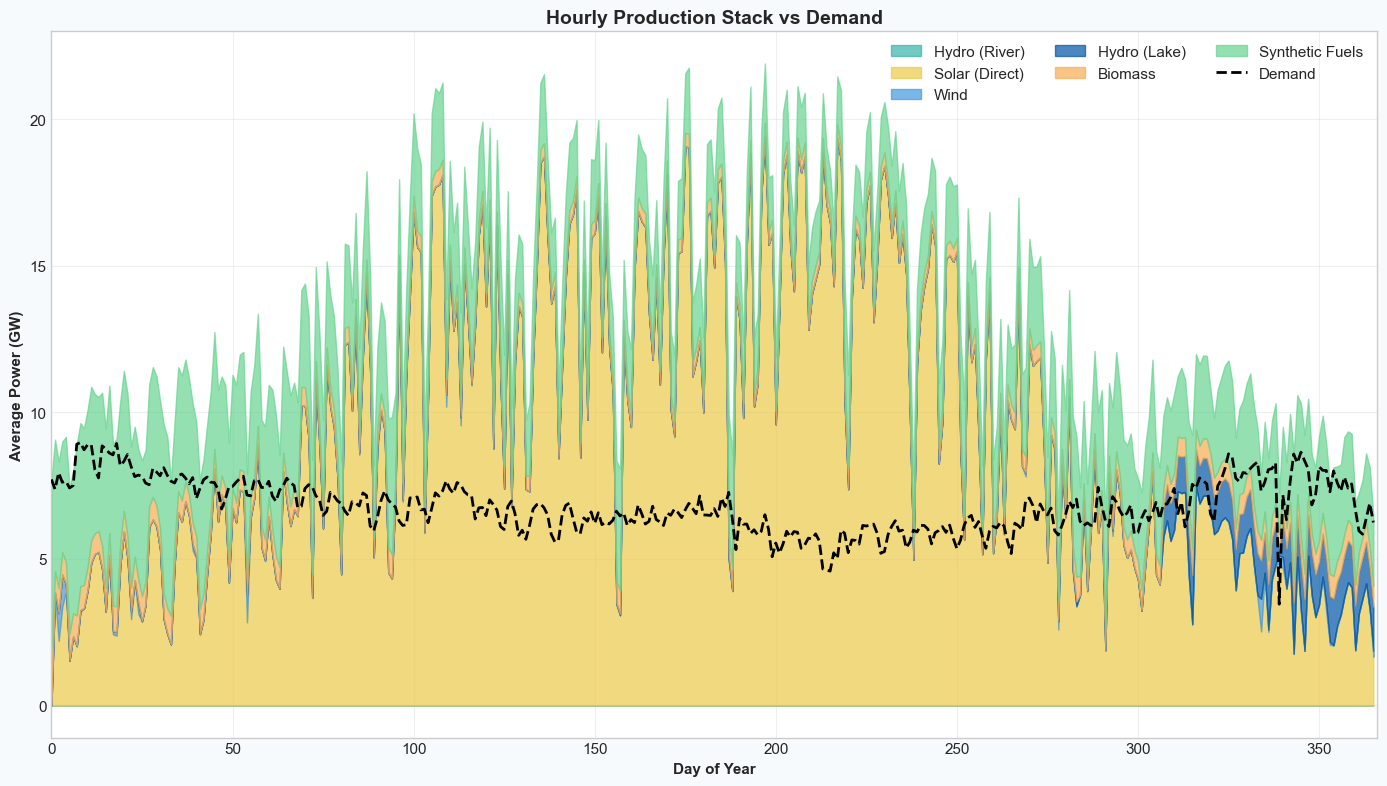

Saved: data/result_plots/dispatch_storage_soc.png


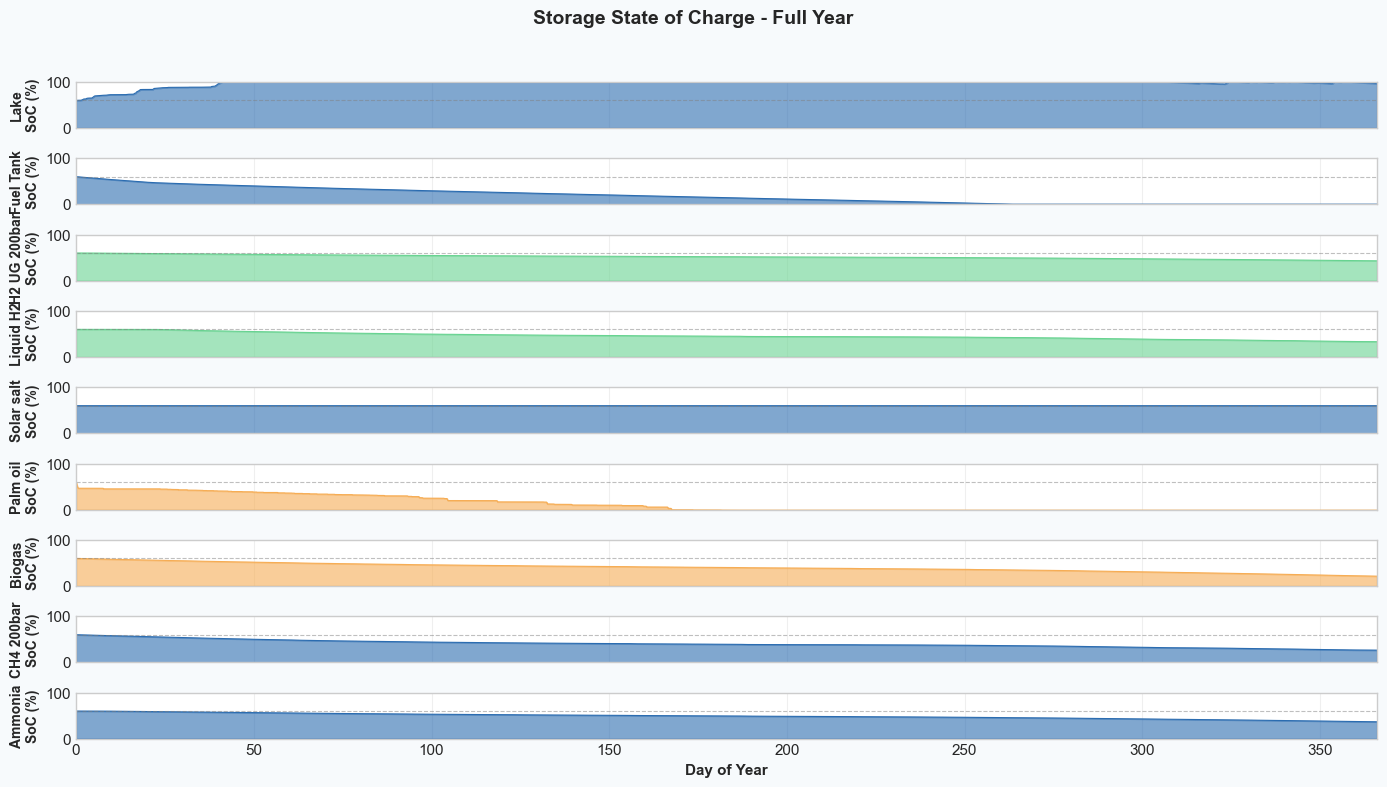

Saved energy balance distribution plot: data/result_plots/dispatch_energy_balance.png


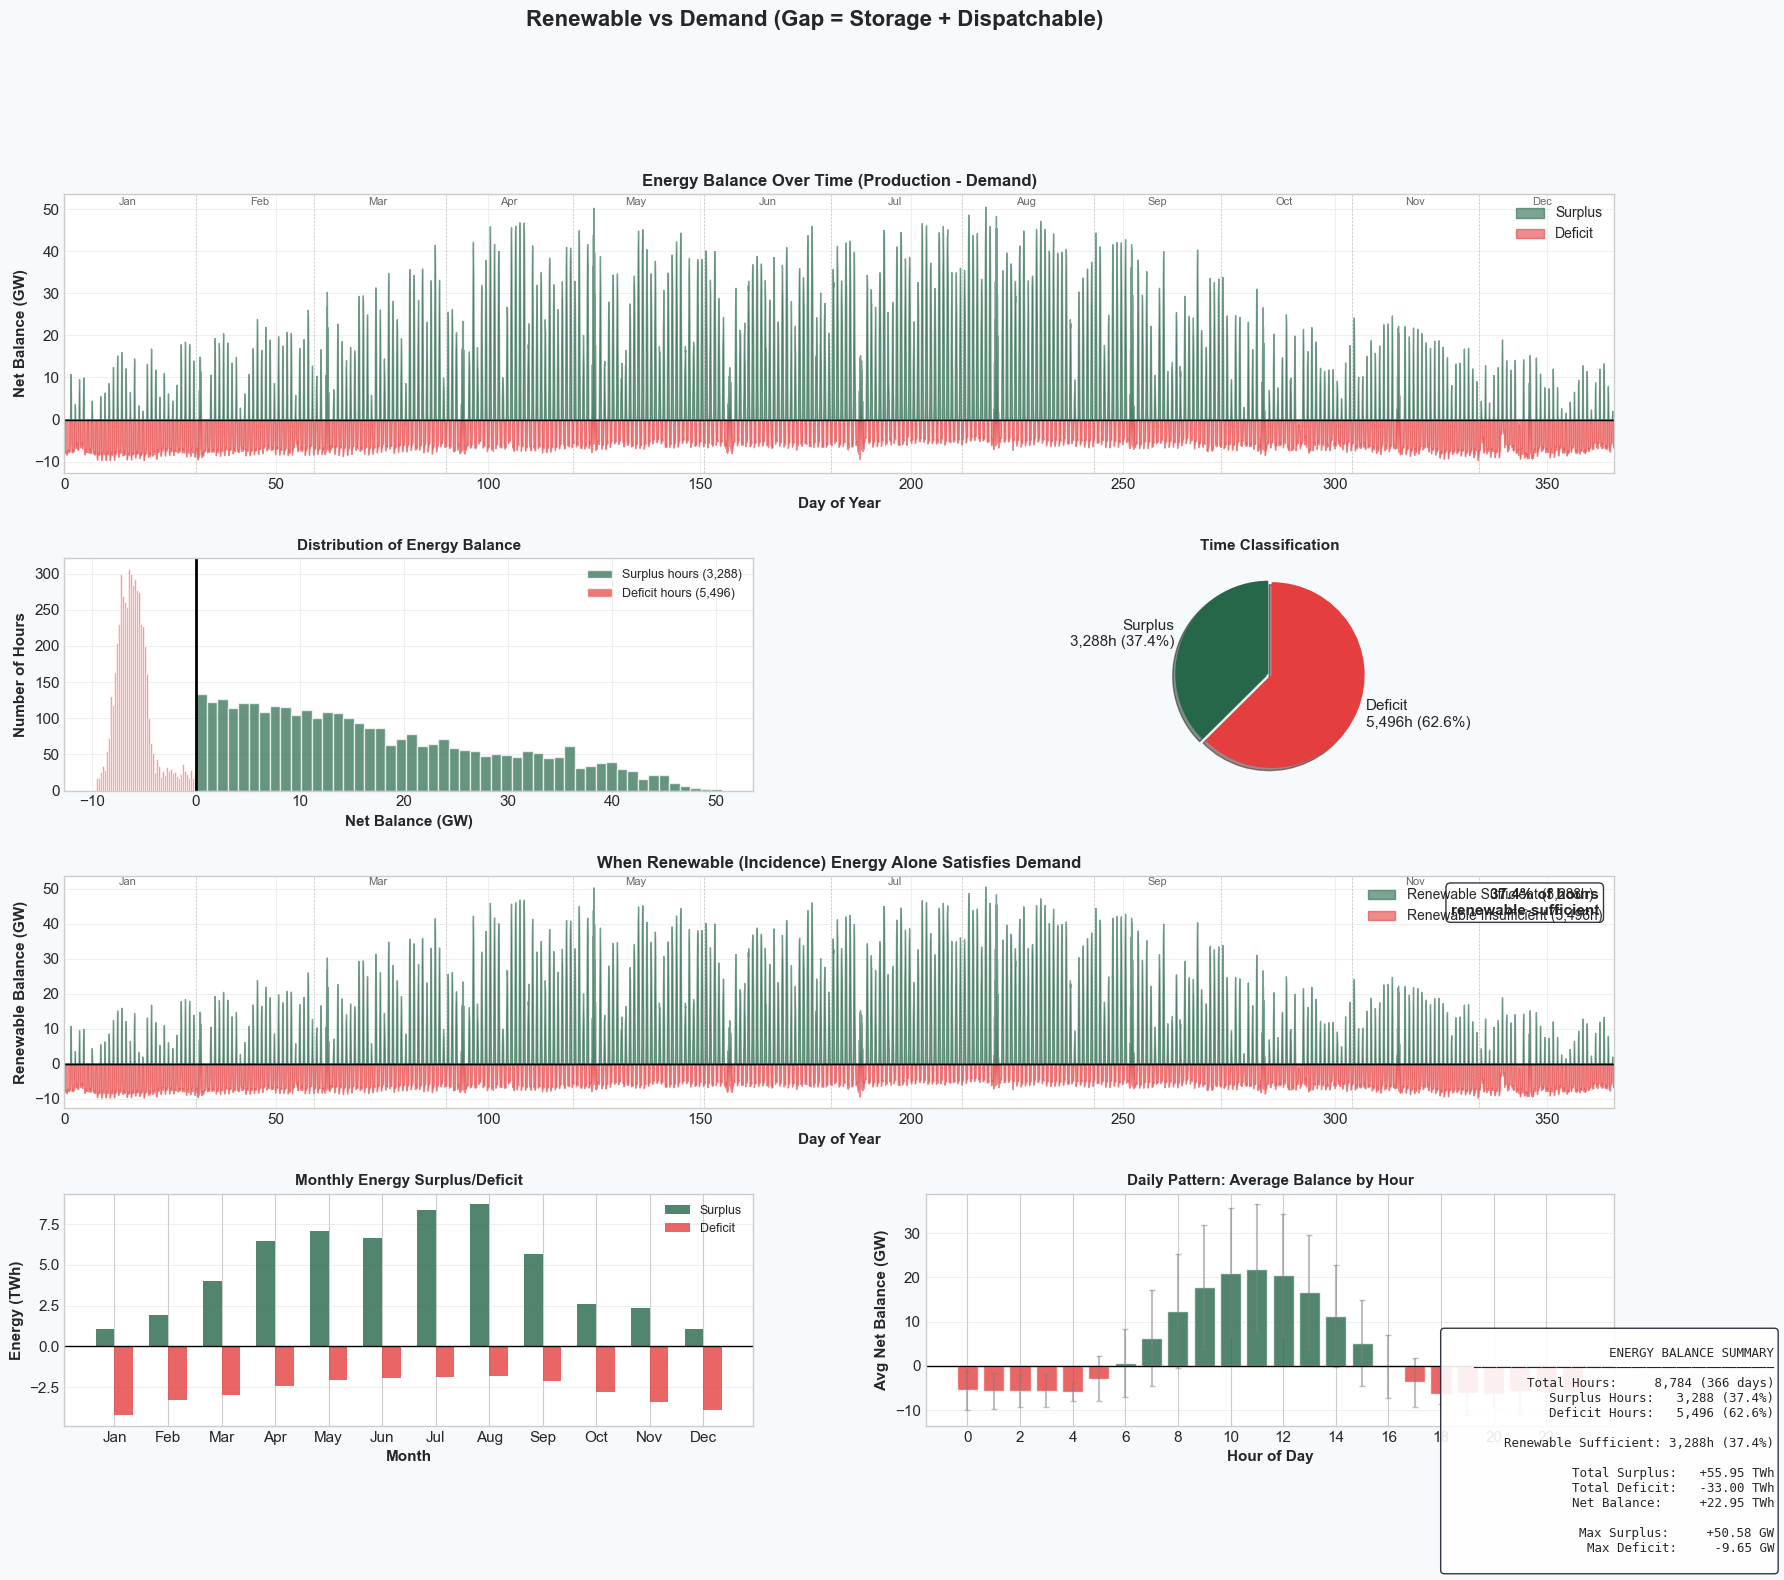

✅ Dispatch visualization complete!


In [80]:
# =============================================================================
# SECTION 1.3: Visualize Dispatch Results
# =============================================================================

# Plot production by source
fig1 = plot_full_year_production_by_source(
    full_year_results,
    title="Hourly Production Stack vs Demand",
    save_path="data/result_plots/dispatch_production_stack.png"
)
plt.show()

# Plot storage state of charge
fig2 = plot_full_year_storage(
    full_year_results,
    title="Storage State of Charge - Full Year",
    save_path="data/result_plots/dispatch_storage_soc.png"
)
plt.show()

# Plot renewable vs demand balance
fig3 = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.renewable_production,
    renewable_production=full_year_results.renewable_production,
    title="Renewable vs Demand (Gap = Storage + Dispatchable)",
    save_path="data/result_plots/dispatch_energy_balance.png"
)
plt.show()

print("✅ Dispatch visualization complete!")


---

# Section 2: Genetic Optimizer

This section uses genetic algorithms to find optimal portfolios.

## System Constraints

### 1. Energy Demand Constraints
| Constraint | Value | Description |
|------------|-------|-------------|
| **Annual Electricity Demand** | 113 TWh/year | 2050 target (Switzerland) |
| **Aviation Fuel Requirement** | 23 TWh/year | Synthetic fuel from Fuel Tank (~2,626 MWh/h) |
| **Energy Sovereignty** | 100% | Must meet demand from portfolio |

### 2. Portfolio Bounds (Unit = 10 MW)
| PPU Type | Min | Max (Hard Cap) | Notes |
|----------|-----|----------------|-------|
| **Renewable** | | | |
| PV | 0 | 1,000 | Up to 10 GW |
| WD_ON | 0 | 1,000 | Up to 10 GW |
| WD_OFF | 0 | 1,000 | Up to 10 GW |
| HYD_R | 0 | 300 | Up to 3 GW (Swiss limit) |
| BIO_WOOD | 0 | 1,000 | Up to 10 GW |
| **Flex/Storage** | | | |
| HYD_S | 0 | 300 | Limited by Lake 2 GW cap |
| PHS | 0 | 1,000 | Pumped hydro |
| H2_G, H2_GL, H2_L | 0 | 1,000 | Hydrogen storage chains |
| SYN_METH, SYN_FT | 0 | 1,000 | Synthetic fuel |
| NH3_FULL | 0 | 1,000 | Ammonia storage |
| THERM, THERM_CH4 | 0 | 1,000 | Thermal generation |

### 3. Progressive Cost Caps
Beyond "soft cap" units, costs increase progressively:

$$\text{cost\_multiplier} = 1 + \text{factor} \times \max(0, \text{units} - \text{soft\_cap})$$

| PPU Type | Soft Cap | Factor | Example: 150 units |
|----------|----------|--------|-------------------|
| PV | 50 (0.5 GW) | 0.02%/unit | 1 + 0.0002×100 = 1.02× |
| WD_ON | 50 | 0.03%/unit | 1.03× |
| WD_OFF | 50 | 0.05%/unit | 1.05× |
| HYD_R | 150 (1.5 GW) | 0.1%/unit | No penalty |
| HYD_S, PHS | 150 | 0.1%/unit | Lake-limited |

### 4. Storage Capacity Caps
| Storage | Max Capacity | Notes |
|---------|--------------|-------|
| Lake | 8.87 TWh (fixed) | Swiss physical limit + water inflow |
| H2 UG 200bar | **50 TWh** | Underground caverns |
| Liquid H2 | **50 TWh** | Cryogenic |
| CH4 200bar | **50 TWh** | Compressed methane |
| Ammonia | **50 TWh** | |
| Fuel Tank | **25 TWh** | Synthetic fuel (also supplies aviation) |
| Biogas | **25 TWh** | |
| Palm oil | 0.5 TWh | Ghost PPU import (only bio-fuel) |

### 5. Power Limits
| Storage | Max Power | Notes |
|---------|-----------|-------|
| Lake (HYD_S) | 2 GW | Physical pump/turbine limit |
| H2 UG 200bar | 5 GW | Compressor limit |
| CH4 200bar | 5 GW | |
| Ammonia | 3 GW | Synthesis limit |
| Biogas | 2 GW | |

---

## Genetic Algorithm Parameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| Population | 20-50 | Number of portfolios per generation |
| Generations | 10-50 | Evolution iterations |
| Tournament Size | 3 | Selection pressure |
| Crossover Rate | 0.8 | Offspring generation |
| Mutation Rate | 0.2 | Random exploration |
| Elite Fraction | 0.1 | Top performers preserved |

## Objective Functions
1. **Return:** Maximize `(spot_price - production_cost) / spot_price × 100`
2. **RoT:** Minimize Risk of Technology (supply chain concentration)
3. **Volatility:** Minimize weekly cost standard deviation

---


In [81]:
# =============================================================================
# SECTION 2.1: Display Portfolio Bounds
# =============================================================================

print("Portfolio Bounds (PPU unit limits):")
print("=" * 60)

bounds = config.ppu.PORTFOLIO_BOUNDS
print(f"{'PPU':<15} {'Min':>8} {'Max':>8} {'Soft Cap':>10}")
print("-" * 45)

for ppu, (min_val, max_val) in sorted(bounds.items()):
    soft_cap = config.ppu.PROGRESSIVE_COST_CAPS.get(ppu, {}).get('soft_cap', '-')
    print(f"{ppu:<15} {min_val:>8} {max_val:>8} {str(soft_cap):>10}")

print("\n" + "=" * 60)


Portfolio Bounds (PPU unit limits):
PPU                  Min      Max   Soft Cap
---------------------------------------------
BIO_WOOD               0     2000       2000
CH4_BIO                0     2000       1000
H2P_G                  0     2000       1000
H2P_L                  0     2000       1000
H2_G                   0     2000       1000
H2_GL                  0     2000       1000
H2_L                   0     2000       1000
HYD_R                  0      300        300
HYD_S                  0      300        150
IMP_BIOG               0     2000       1000
NH3_FULL               0     2000       1000
NH3_P                  0     2000       1000
PALM_ICE               0     2000       1000
PHS                    0     2000       1000
PV                     0     2000       2000
SOL_SALT               0     2000       1000
SOL_SALT_STORE         0     2000       1000
SOL_STEAM              0     2000       1000
SYN_CRACK              0     2000       1000
SYN_FT            

In [82]:
# =============================================================================
# SECTION 2.2: Run Multi-Objective Exploration (GA)
# =============================================================================

from multi_objective_explorer import get_objective_configs

print("=" * 60)
print("MULTI-OBJECTIVE GENETIC ALGORITHM")
print("=" * 60)

# Configuration
N_GENERATIONS = 10  # Increase for better coverage
POP_SIZE = 20       # Increase for better diversity
OUTPUT_PATH = "data/result_plots/multi_objective_results.csv"

# Get predefined objectives (cost, rot, volatility, balanced, rot_heavy, vol_heavy)
objectives = get_objective_configs()

print(f"Objectives: {len(objectives)}")
for obj in objectives:
    print(f"  • {obj.name}: {obj.description}")

print(f"\nGenerations per objective: {N_GENERATIONS}")
print(f"Population size: {POP_SIZE}")
print(f"Output: {OUTPUT_PATH}")
print("\n" + "=" * 60)


MULTI-OBJECTIVE GENETIC ALGORITHM
Objectives: 6
  • cost: Minimize cost (maximize return)
  • rot: Minimize Risk of Technology
  • volatility: Minimize Volatility
  • rot_vol_balanced: Balanced RoT and Volatility
  • rot_heavy: Heavy RoT weight (80%)
  • vol_heavy: Heavy Volatility weight (80%)

Generations per objective: 10
Population size: 20
Output: data/result_plots/multi_objective_results.csv



In [83]:
# =============================================================================
# SECTION 2.3: Execute Multi-Objective GA
# =============================================================================

# Run exploration (this can take 30-60 minutes)
all_results_df, pareto_df = explore_and_find_frontier(
    config=config,
    objectives=objectives,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    output_path=OUTPUT_PATH,
    verbose=True,
    use_existing_as_seeds=False
)

print("\n" + "=" * 60)
print(f"✅ Exploration complete!")
print(f"   Total portfolios: {len(all_results_df)}")
print(f"   Frontier portfolios: {len(pareto_df)}")


MULTI-OBJECTIVE PORTFOLIO EXPLORATION
Objectives: 6
Generations per objective: 10
Population size: 20
Shared initial population: True

Generating shared initial population...


Evaluating initial population: 100%|██████████| 20/20 [02:13<00:00,  6.67s/it]


Valid portfolios in initial population: 10/20


Objective: cost
Description: Minimize cost (maximize return)
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 31.8733
  RoT: 0.4211
  Volatility: 29.74
  Return: -31.87%
Evaluated 189 portfolios for 'cost'

Objective: rot
Description: Minimize Risk of Technology
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.4190
  RoT: 0.4190
  Volatility: 30.07
  Return: -44.49%
Evaluated 189 portfolios for 'rot'

Objective: volatility
Description: Minimize Volatility
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 6.0460
  RoT: 0.5171
  Volatility: 6.05
  Return: -75.97%
Evaluated 190 portfolios for 'volatility'

Objective: rot_vol_balanced
Description: Balanced RoT and Volatility
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.2363
  RoT: 0.4442
  Volatility: 28.37
  Return: -45.75%
Evaluated 189 portfolios for 'rot_vol_balan

---

# Section 3: Pareto Frontier Analysis

This section identifies the 3D Pareto frontier and analyzes frontier portfolios.

## Constraints

### Pareto Dominance
Portfolio A dominates Portfolio B if:
- A is at least as good as B in all objectives
- A is strictly better than B in at least one objective

The Pareto frontier contains all non-dominated portfolios.

### 3D Metrics Definitions
| Metric | Definition | Optimization Goal |
|--------|------------|-------------------|
| **RoT** | Risk of Technology - supply chain concentration (0-1) | Minimize |
| **Volatility** | Weekly std of production costs (CHF/MWh) | Minimize |
| **Return** | (spot_price - production_cost) / spot_price × 100% | Maximize |

---


In [84]:
# =============================================================================
# SECTION 3.1: Find 3D Pareto Frontier
# =============================================================================

def find_3d_pareto_frontier(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find 3D Pareto frontier: minimize RoT, minimize volatility, maximize return.
    """
    rot = df['x_RoT'].values
    vol = df['y_volatility'].values
    ret = -df['z_return'].values  # Negate because we maximize return
    
    n = len(df)
    is_dominated = np.zeros(n, dtype=bool)
    
    for i in range(n):
        if is_dominated[i]:
            continue
        for j in range(n):
            if i == j or is_dominated[j]:
                continue
            # Check if j dominates i
            if (rot[j] <= rot[i] and vol[j] <= vol[i] and ret[j] <= ret[i] and
                (rot[j] < rot[i] or vol[j] < vol[i] or ret[j] < ret[i])):
                is_dominated[i] = True
                break
    
    return df[~is_dominated].copy()

# Load results if not in memory
if 'all_results_df' not in dir() or all_results_df is None:
    all_results_df = pd.read_csv(OUTPUT_PATH)

# Find 3D frontier
frontier_3d = find_3d_pareto_frontier(all_results_df)

print(f"3D Pareto Frontier: {len(frontier_3d)} portfolios")
print(f"\nFrontier ranges:")
print(f"  RoT: [{frontier_3d['x_RoT'].min():.4f}, {frontier_3d['x_RoT'].max():.4f}]")
print(f"  Volatility: [{frontier_3d['y_volatility'].min():.2f}, {frontier_3d['y_volatility'].max():.2f}]")
print(f"  Return: [{frontier_3d['z_return'].min():.2f}%, {frontier_3d['z_return'].max():.2f}%]")

# Save frontier
frontier_path = "data/result_plots/multi_objective_results_final_frontier_3d.csv"
frontier_3d.to_csv(frontier_path, index=False)
print(f"\nFrontier saved to: {frontier_path}")


3D Pareto Frontier: 35 portfolios

Frontier ranges:
  RoT: [0.4148, 0.5173]
  Volatility: [5.63, 33.07]
  Return: [-76.32%, -21.15%]

Frontier saved to: data/result_plots/multi_objective_results_final_frontier_3d.csv


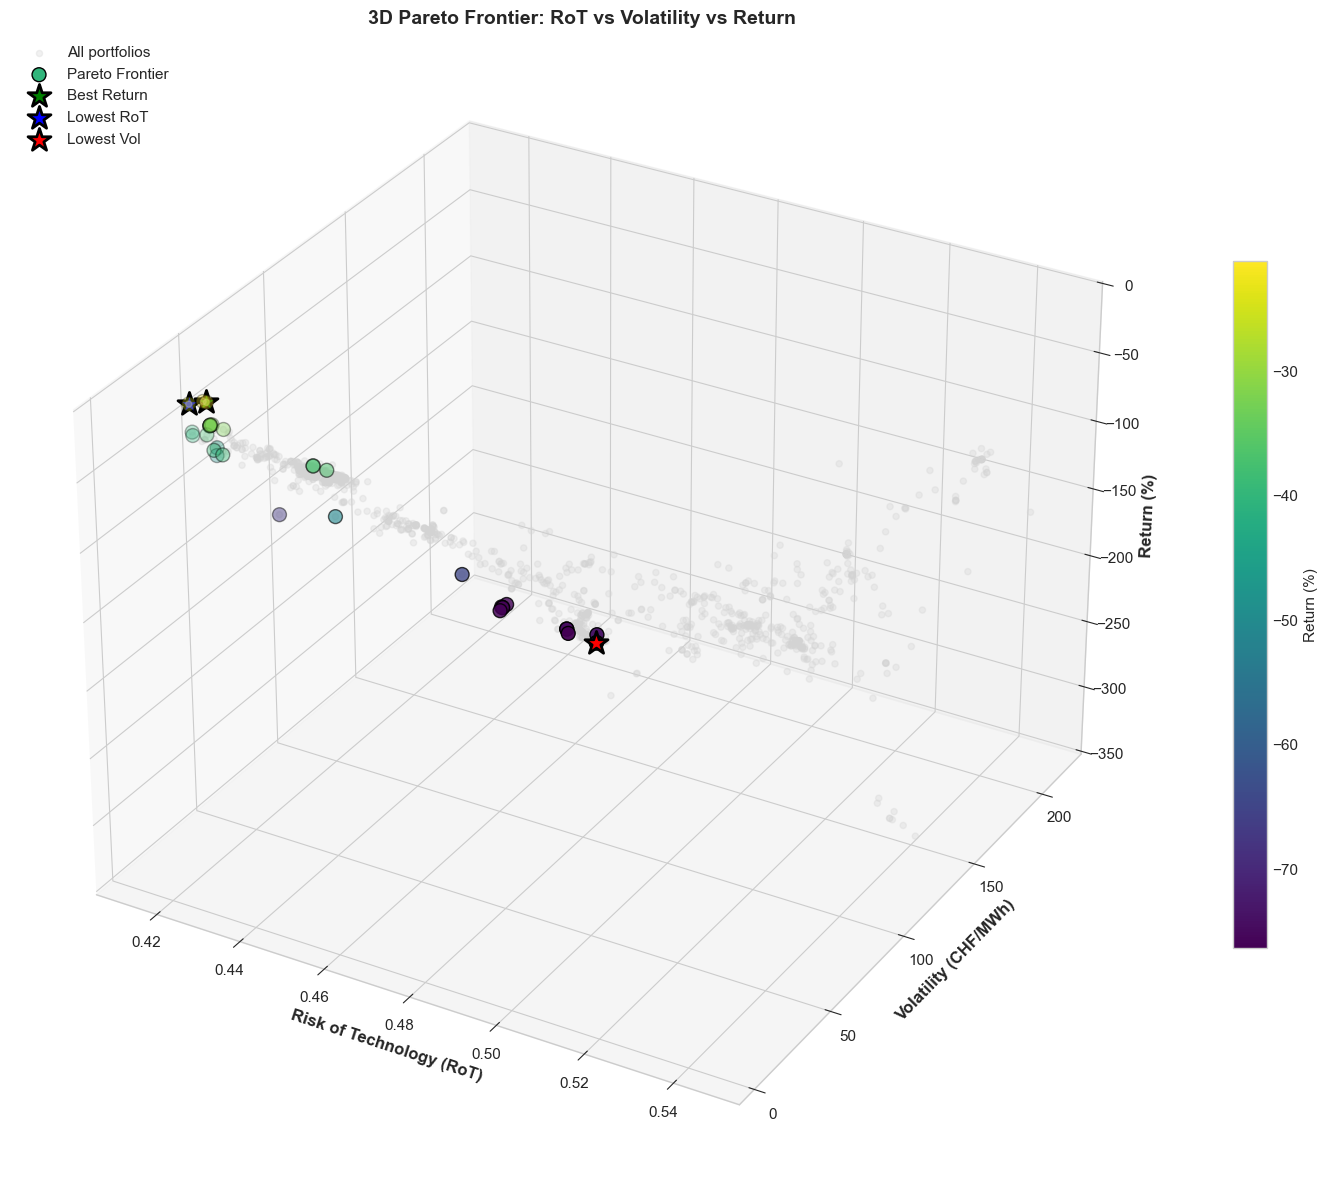

✅ 3D Pareto frontier visualization saved!


In [85]:
# =============================================================================
# SECTION 3.2: Visualize 3D Pareto Frontier
# =============================================================================

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all portfolios
ax.scatter(
    all_results_df['x_RoT'], all_results_df['y_volatility'], all_results_df['z_return'],
    c='lightgray', alpha=0.3, s=20, label='All portfolios'
)

# Plot frontier
scatter = ax.scatter(
    frontier_3d['x_RoT'], frontier_3d['y_volatility'], frontier_3d['z_return'],
    c=frontier_3d['z_return'], cmap='viridis',
    s=100, edgecolors='black', linewidth=1, label='Pareto Frontier'
)

# Highlight extreme points
best_return = frontier_3d.loc[frontier_3d['z_return'].idxmax()]
best_rot = frontier_3d.loc[frontier_3d['x_RoT'].idxmin()]
best_vol = frontier_3d.loc[frontier_3d['y_volatility'].idxmin()]

ax.scatter([best_return['x_RoT']], [best_return['y_volatility']], [best_return['z_return']],
          c='green', s=300, marker='*', edgecolors='black', linewidth=2, label='Best Return')
ax.scatter([best_rot['x_RoT']], [best_rot['y_volatility']], [best_rot['z_return']],
          c='blue', s=300, marker='*', edgecolors='black', linewidth=2, label='Lowest RoT')
ax.scatter([best_vol['x_RoT']], [best_vol['y_volatility']], [best_vol['z_return']],
          c='red', s=300, marker='*', edgecolors='black', linewidth=2, label='Lowest Vol')

ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold')
ax.set_zlabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('3D Pareto Frontier: RoT vs Volatility vs Return', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='Return (%)', shrink=0.6)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('data/result_plots/pareto_frontier_3d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 3D Pareto frontier visualization saved!")


In [86]:
# =============================================================================
# SECTION 3.3: Analyze Frontier Portfolios
# =============================================================================

print("=" * 60)
print("PARETO FRONTIER PORTFOLIOS")
print("=" * 60)

for idx, (_, row) in enumerate(frontier_3d.iterrows()):
    print(f"\nPortfolio #{idx+1}:")
    print(f"  RoT:        {row['x_RoT']:.4f}")
    print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
    print(f"  Return:     {row['z_return']:.2f}%")
    
    # Parse portfolio
    pf_dict = json.loads(row['portfolio_dict']) if isinstance(row['portfolio_dict'], str) else row['portfolio_dict']
    top_ppus = sorted(pf_dict.items(), key=lambda x: -x[1])[:5]
    print(f"  Top PPUs: {', '.join(f'{p}:{c}' for p, c in top_ppus)}")

print("\n" + "=" * 60)


PARETO FRONTIER PORTFOLIOS

Portfolio #1:
  RoT:        0.4166
  Volatility: 29.08 CHF/MWh
  Return:     -40.33%
  Top PPUs: PALM_ICE:1940, CH4_BIO:1806, SOL_STEAM:1664, H2_G:1641, THERM_CH4:1558

Portfolio #2:
  RoT:        0.4230
  Volatility: 27.50 CHF/MWh
  Return:     -44.37%
  Top PPUs: PALM_ICE:2000, CH4_BIO:1806, H2_G:1578, H2_L:1563, THERM_CH4:1558

Portfolio #3:
  RoT:        0.4200
  Volatility: 31.05 CHF/MWh
  Return:     -34.62%
  Top PPUs: PALM_ICE:1940, H2_G:1854, CH4_BIO:1806, SOL_STEAM:1664, H2_L:1563

Portfolio #4:
  RoT:        0.4173
  Volatility: 27.51 CHF/MWh
  Return:     -40.64%
  Top PPUs: PALM_ICE:1940, CH4_BIO:1806, SOL_STEAM:1664, H2_G:1641, THERM_CH4:1606

Portfolio #5:
  RoT:        0.4200
  Volatility: 30.96 CHF/MWh
  Return:     -34.73%
  Top PPUs: CH4_BIO:2000, PALM_ICE:1940, H2_G:1854, SOL_STEAM:1664, H2_L:1563

Portfolio #6:
  RoT:        0.4211
  Volatility: 29.74 CHF/MWh
  Return:     -31.87%
  Top PPUs: CH4_BIO:2000, PALM_ICE:1939, THERM_CH4:1629, 

In [87]:
# =============================================================================
# FRONTIER RESEARCH: Systematic Exploration Along the Pareto Line
# =============================================================================

# Get data from cached_data (same as cell 4)
solar_production = cached_data.get_solar_incidence(copy=False)
wind_production = cached_data.get_wind_incidence(copy=False)
spot_price = cached_data.get_spot_prices(copy=False)

# Create ppu_dictionary for the frontier research (using test_portfolio or a default)
# We need to create a placeholder since frontier_research will create its own for each portfolio
from ppu_framework import create_ppu_dictionary, assign_renewable_locations
ppu_dictionary = create_ppu_dictionary(
    Portfolio(ppu_counts={}),  # Empty - will be filled per portfolio
    ppu_definitions, 
    config
)

# Wrapper: run full year simulation using existing evaluate_portfolio_full_year
def run_full_year_simulation(portfolio_counts, ppu_dictionary, demand_data, spot_data,
                              solar_data, wind_data, water_inflow_data, config, 
                              ppu_definitions, verbose=False):
    from optimization import Individual, evaluate_portfolio_full_year
    from ppu_framework import Portfolio
    
    portfolio = Portfolio(ppu_counts=portfolio_counts)
    individual = Individual(portfolio=portfolio)
    return evaluate_portfolio_full_year(individual, config, verbose=verbose)

# Wrapper: calculate metrics using existing calculate_portfolio_metrics_3d
def calculate_portfolio_metrics(full_year_results, ppu_definitions, spot_data, 
                                  portfolio_counts, config):
    from optimization import Individual
    from ppu_framework import Portfolio
    from portfolio_metrics import calculate_portfolio_metrics_3d
    from risk_calculator import RiskCalculator
    
    portfolio = Portfolio(ppu_counts=portfolio_counts)
    individual = Individual(portfolio=portfolio)
    risk_calculator = RiskCalculator(config)
    metrics = calculate_portfolio_metrics_3d(individual, config, risk_calculator, debug=False)
    
    # Map attributes (x_rot -> risk_of_technology, etc.)
    class CompatibleMetrics:
        def __init__(self, m):
            self.risk_of_technology = m.x_rot
            self.volatility = m.y_volatility
            self.mean_return = m.z_return
            self.total_energy_twh = m.total_energy_twh
    return CompatibleMetrics(metrics)

# Configure research parameters
research_config = FrontierResearchConfig(
    alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    verbose=True,
    output_path='data/result_plots/extended_frontier_research.csv'
)

# Run frontier research
frontier_results = run_frontier_research(
    frontier_path='data/result_plots/multi_objective_results_final_frontier_3d.csv',
    run_simulation_func=run_full_year_simulation,
    calculate_metrics_func=calculate_portfolio_metrics,
    ppu_dictionary=ppu_dictionary,
    demand_data=demand,
    spot_data=spot_price,
    solar_data=solar_production,
    wind_data=wind_production,
    water_inflow_data=water_inflow,
    config=config,
    ppu_definitions=ppu_definitions,
    research_config=research_config
)


FRONTIER RESEARCH: Pushing Along the Pareto Line

Loaded 35 frontier portfolios
Return range: -76.32% to -21.15%
RoT range: 0.4148 to 0.5173
Volatility range: 5.63 to 33.07

----------------------------------------
Step 1: Identifying Anchor Points
----------------------------------------
  Best Return: Return=-21.15%, RoT=0.4186, Vol=33.01
  Lowest RoT: Return=-24.59%, RoT=0.4148, Vol=31.89
  Lowest Volatility: Return=-75.88%, RoT=0.5173, Vol=5.63

----------------------------------------
Step 2: Generating Interpolated Portfolios
----------------------------------------
  Generated 27 interpolated portfolios

----------------------------------------
Step 3: Evaluating Portfolios
----------------------------------------
  Evaluated 9/27 portfolios
  Evaluated 18/27 portfolios
  Evaluated 27/27 portfolios
  Successfully evaluated: 27 portfolios

----------------------------------------
Step 4: Identifying Improvements
----------------------------------------
  Found 10 potentially impr

---

## 3.5 Pareto Frontier 3D Visualization

The **Pareto frontier** represents the set of optimal portfolios where no objective can be improved without sacrificing another. In our 3-objective optimization:

| Axis | Metric | Goal |
|------|--------|------|
| **X** | Volatility (CHF/MWh) | Minimize |
| **Y** | Risk of Technology (RoT) | Minimize |
| **Z** | Return (%) | Maximize |

### Frontier Surface Interpretation

The fitted surface below represents the **efficient frontier**—the boundary of achievable performance. Portfolios:
- **On the surface**: Pareto-optimal (no free improvements exist)
- **Below the surface**: Sub-optimal (dominated by frontier portfolios)
- **Above the surface**: Currently unachievable with available technologies

The surface curvature reveals **trade-off regions**:
- Steep gradients indicate expensive trade-offs
- Flat regions suggest similar portfolios with minor metric differences


In [ ]:
# =============================================================================
# AVIATION-COMPLIANT FRONTIER BOWL VISUALIZATION
# =============================================================================
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from scipy.interpolate import griddata

def plot_compliant_frontier_bowl():
    """
    Plot aviation-compliant portfolios within a bowl-shaped frontier surface.
    Uses only compliant portfolios to define the boundary.
    """
    frontier_df = pd.read_csv('data/result_plots/multi_objective_results_final_frontier_3d.csv')
    
    # =========================================================================
    # FILTER TO AVIATION-COMPLIANT PORTFOLIOS ONLY
    # =========================================================================
    MIN_THERM_FOR_AVIATION = 263
    
    aviation_compliant = []
    for idx, row in frontier_df.iterrows():
        try:
            import json as _json
            portfolio = _json.loads(row['portfolio_dict']) if isinstance(row['portfolio_dict'], str) else row['portfolio_dict']
            therm_count = portfolio.get('THERM', 0)
            syn_ft_count = portfolio.get('SYN_FT', 0)
            compliant = therm_count >= MIN_THERM_FOR_AVIATION and syn_ft_count > 0
            aviation_compliant.append(compliant)
        except:
            aviation_compliant.append(False)
    
    compliant_mask = np.array(aviation_compliant)
    compliant_df = frontier_df[compliant_mask].copy()
    
    if len(compliant_df) < 4:
        print("❌ Not enough aviation-compliant portfolios for surface fitting")
        return
    
    # Extract compliant points only
    x = compliant_df['y_volatility'].values  # Volatility (minimize)
    y = compliant_df['x_RoT'].values         # Risk of Technology (minimize)
    z = compliant_df['z_return'].values      # Return (maximize)
    
    print(f"📊 Using {len(compliant_df)} aviation-compliant portfolios")
    
    # =========================================================================
    # COMPUTE 2D CONVEX HULL (for boundary in Vol-RoT plane)
    # =========================================================================
    points_2d = np.column_stack([x, y])
    hull_2d = ConvexHull(points_2d)
    
    # =========================================================================
    # COMPUTE 3D CONVEX HULL for the upper surface (MUST BE BEFORE SURFACE BUILDING)
    # =========================================================================
    points_3d = np.column_stack([x, y, z])
    hull_3d = ConvexHull(points_3d)
    
    # Get upper faces (normals pointing UPWARD - positive z-component)
    # These faces form the "ceiling" of the bowl (maximum return for given vol/RoT)
    upper_faces = []
    for simplex in hull_3d.simplices:
        v0, v1, v2 = points_3d[simplex]
        # Calculate face normal (pointing outward from hull)
        edge1 = v1 - v0
        edge2 = v2 - v0
        normal = np.cross(edge1, edge2)
        norm_len = np.linalg.norm(normal)
        
        if norm_len > 1e-10:
            normal = normal / norm_len
            
            # For upper surface: normal should point UP (positive z)
            # Also check that the face is actually on the upper envelope
            # by verifying all three vertices have relatively high return
            face_returns = [v0[2], v1[2], v2[2]]
            avg_face_return = np.mean(face_returns)
            
            # Keep faces with upward normal AND high return (upper envelope)
            if normal[2] > 0.3 and avg_face_return > np.percentile(z, 25):
                upper_faces.append(simplex)
    
    upper_faces = np.array(upper_faces) if len(upper_faces) > 0 else None
    
    if upper_faces is None or len(upper_faces) == 0:
        print("⚠️ No upper faces found, computing from maximum return envelope")
        # Fallback: find faces that maximize return for their (vol, RoT) region
        upper_faces = []
        for simplex in hull_3d.simplices:
            v0, v1, v2 = points_3d[simplex]
            # Check if this face is part of the upper envelope
            # by comparing its return to nearby points
            face_center_2d = np.mean([v0[:2], v1[:2], v2[:2]], axis=0)
            face_return = np.mean([v0[2], v1[2], v2[2]])
            
            # Find nearby points
            distances = np.sqrt(np.sum((points_2d - face_center_2d)**2, axis=1))
            nearby_mask = distances < np.percentile(distances, 20)
            if nearby_mask.sum() > 0:
                nearby_returns = z[nearby_mask]
                # If this face's return is in top 50% of nearby points, it's upper
                if face_return >= np.percentile(nearby_returns, 50):
                    upper_faces.append(simplex)
        
        upper_faces = np.array(upper_faces) if len(upper_faces) > 0 else hull_3d.simplices
    
    # =========================================================================
    # CREATE CONVEX BOWL SURFACE - Guaranteed convex, smooth, no spikes
    # =========================================================================
    # Grid for interpolation
    grid_res = 60
    x_margin = (x.max() - x.min()) * 0.05
    y_margin = (y.max() - y.min()) * 0.05
    
    xi = np.linspace(x.min() - x_margin, x.max() + x_margin, grid_res)
    yi = np.linspace(y.min() - y_margin, y.max() + y_margin, grid_res)
    xi_mesh, yi_mesh = np.meshgrid(xi, yi)
    grid_points = np.column_stack([xi_mesh.ravel(), yi_mesh.ravel()])
    
    # Use Delaunay to mask points outside the data convex hull
    delaunay = Delaunay(points_2d)
    inside_mask = delaunay.find_simplex(grid_points) >= 0
    inside_mask = inside_mask.reshape(xi_mesh.shape)
    
    # =========================================================================
    # Build convex bowl surface - MAXIMUM return for each (vol, RoT) point
    # Bowl opens UPWARD toward positive return
    # Low vol + Low RoT → High return (top)
    # High vol + High RoT → Low return (bottom)
    # =========================================================================
    zi = np.full(xi_mesh.shape, np.nan)
    
    # For each grid point inside the hull, find MAXIMUM return (upper envelope)
    for i in range(grid_res):
        for j in range(grid_res):
            if inside_mask[i, j]:
                vol_target = xi_mesh[i, j]
                rot_target = yi_mesh[i, j]
                target_2d = np.array([vol_target, rot_target])
                
                # Find MAXIMUM return from all upper faces that could contain this point
                best_return = -np.inf
                
                # Method 1: Check upper hull faces (most accurate)
                for simplex in upper_faces:
                    p0 = points_3d[simplex[0]]
                    p1 = points_3d[simplex[1]]
                    p2 = points_3d[simplex[2]]
                    
                    # Project to 2D (vol, RoT plane)
                    v0_2d = p0[:2]
                    v1_2d = p1[:2]
                    v2_2d = p2[:2]
                    
                    # Barycentric coordinates to check if point is inside triangle
                    v0v1 = v1_2d - v0_2d
                    v0v2 = v2_2d - v0_2d
                    v0t = target_2d - v0_2d
                    
                    dot00 = np.dot(v0v2, v0v2)
                    dot01 = np.dot(v0v2, v0v1)
                    dot02 = np.dot(v0v2, v0t)
                    dot11 = np.dot(v0v1, v0v1)
                    dot12 = np.dot(v0v1, v0t)
                    
                    denom = dot00 * dot11 - dot01 * dot01
                    if abs(denom) > 1e-10:
                        inv_denom = 1.0 / denom
                        u = (dot11 * dot02 - dot01 * dot12) * inv_denom
                        v = (dot00 * dot12 - dot01 * dot02) * inv_denom
                        
                        # If inside triangle (u >= 0, v >= 0, u+v <= 1)
                        if u >= -0.01 and v >= -0.01 and (u + v) <= 1.01:
                            # Linear interpolation of return (barycentric)
                            w0 = 1 - u - v
                            w1 = u
                            w2 = v
                            interpolated_return = w0 * p0[2] + w1 * p1[2] + w2 * p2[2]
                            best_return = max(best_return, interpolated_return)
                
                # Method 2: If no face found, use distance-weighted max from nearby portfolios
                if best_return == -np.inf:
                    # Find portfolios near this (vol, RoT) point
                    distances_2d = np.sqrt((x - vol_target)**2 + (y - rot_target)**2)
                    
                    # Use inverse distance weighting, but only take MAXIMUM return
                    # This ensures we get the upper envelope
                    nearby_mask = distances_2d < np.percentile(distances_2d, 30)
                    if nearby_mask.sum() > 0:
                        # Take maximum return from nearby points (upper envelope)
                        best_return = np.max(z[nearby_mask])
                    else:
                        # Fallback: nearest neighbor
                        nearest_idx = np.argmin(distances_2d)
                        best_return = z[nearest_idx]
                
                zi[i, j] = best_return
    
    # =========================================================================
    # Apply heavy Gaussian smoothing for ultra-smooth convex bowl
    # =========================================================================
    from scipy.ndimage import gaussian_filter
    
    # Smooth the surface
    zi_smooth = zi.copy()
    zi_smooth[~inside_mask] = 0  # Fill NaN with 0 for smoothing
    
    # Heavy smoothing (large sigma) for very smooth bowl
    zi_smoothed = gaussian_filter(zi_smooth, sigma=4.0)
    
    # Restore NaN outside the hull
    zi_smoothed[~inside_mask] = np.nan
    
    # Ensure surface is upper envelope (at least as high as actual portfolios)
    for k in range(len(x)):
        i_idx = np.argmin(np.abs(xi - x[k]))
        j_idx = np.argmin(np.abs(yi - y[k]))
        if inside_mask[i_idx, j_idx]:
            zi_smoothed[i_idx, j_idx] = max(zi_smoothed[i_idx, j_idx], z[k])
    
    zi = zi_smoothed
    
    # =========================================================================
    # FIGURE
    # =========================================================================
    fig = go.Figure()
    
    # 1. BOWL SURFACE (upper envelope of compliant portfolios)
    fig.add_trace(go.Surface(
        x=xi_mesh, y=yi_mesh, z=zi,
        colorscale='Plasma',
        opacity=0.6,
        colorbar=dict(title='Return (%)', x=1.02, len=0.7),
        name='Frontier Bowl',
        showscale=True,
        contours=dict(
            z=dict(show=True, usecolormap=True, highlightcolor="white", project_z=True, width=1),
        ),
        lighting=dict(ambient=0.4, diffuse=0.7, specular=0.5, roughness=0.2),
        hovertemplate='<b>Frontier Surface</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # 2. CONVEX HULL UPPER MESH (triangulated surface)
    if upper_faces is not None and len(upper_faces) > 0:
        fig.add_trace(go.Mesh3d(
            x=x, y=y, z=z,
            i=upper_faces[:, 0], j=upper_faces[:, 1], k=upper_faces[:, 2],
            opacity=0.25,
            color='cyan',
            name='Convex Hull (Upper)',
            flatshading=False,
            hoverinfo='skip'
        ))
    
    # 3. COMPLIANT PORTFOLIOS (inside the bowl)
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=8, 
            color=z,  # Color by return
            colorscale='Viridis',
            symbol='circle',
            line=dict(width=1, color='white'),
            opacity=0.9
        ),
        name=f'✅ Aviation Compliant ({len(x)})',
        hovertemplate='<b>Compliant Portfolio</b><br>Vol: %{x:.2f} CHF/MWh<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # 4. CORNER PORTFOLIOS (hull vertices - extreme trade-offs)
    hull_vertex_indices = hull_3d.vertices
    fig.add_trace(go.Scatter3d(
        x=x[hull_vertex_indices], y=y[hull_vertex_indices], z=z[hull_vertex_indices],
        mode='markers+text',
        marker=dict(size=12, color='gold', symbol='diamond', line=dict(width=2, color='black')),
        text=[f'#{i+1}' for i in range(len(hull_vertex_indices))],
        textposition='top center',
        textfont=dict(size=10, color='white'),
        name=f'Corner Portfolios ({len(hull_vertex_indices)})',
        hovertemplate='<b>🔶 Corner Portfolio</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # 5. 2D HULL BOUNDARY (projected on bottom)
    hull_boundary_x = np.append(x[hull_2d.vertices], x[hull_2d.vertices[0]])
    hull_boundary_y = np.append(y[hull_2d.vertices], y[hull_2d.vertices[0]])
    hull_boundary_z = np.full_like(hull_boundary_x, z.min() - 2)  # Project below
    
    fig.add_trace(go.Scatter3d(
        x=hull_boundary_x, y=hull_boundary_y, z=hull_boundary_z,
        mode='lines',
        line=dict(color='cyan', width=4),
        name='Feasible Region Boundary',
        hoverinfo='skip'
    ))
    
    # Layout
    fig.update_layout(
        title=dict(
            text='<b>Aviation-Compliant Frontier Bowl</b><br>'
                 '<sup>Portfolios within the achievable performance envelope | Gold = Corner portfolios</sup>',
            x=0.5
        ),
        scene=dict(
            xaxis=dict(title='Volatility (CHF/MWh)', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white')),
            yaxis=dict(title='Risk of Technology', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white')),
            zaxis=dict(title='Return (%)', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white')),
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.0)),  # Higher angle to see bowl
            aspectmode='cube'
        ),
        paper_bgcolor='#0f0f1a',
        plot_bgcolor='#0f0f1a',
        font=dict(color='white'),
        margin=dict(l=0, r=50, t=100, b=0),
        height=750,
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(30,30,50,0.9)', font=dict(color='white'))
    )
    fig.show()
    
    # =========================================================================
    # STATISTICS
    # =========================================================================
    print(f"\n{'='*70}")
    print("AVIATION-COMPLIANT FRONTIER BOWL ANALYSIS")
    print('='*70)
    print(f"\n📊 Compliant Portfolio Statistics:")
    print(f"   Total compliant:       {len(compliant_df)}")
    print(f"   Convex hull vertices:  {len(hull_3d.vertices)}")
    print(f"\n📈 Performance Ranges (Compliant Only):")
    print(f"   Return:     [{z.min():.2f}%, {z.max():.2f}%]")
    print(f"   Volatility: [{x.min():.2f}, {x.max():.2f}] CHF/MWh")
    print(f"   RoT:        [{y.min():.4f}, {y.max():.4f}]")
    
    # Find best portfolios
    best_return_idx = np.argmax(z)
    best_rot_idx = np.argmin(y)
    best_vol_idx = np.argmin(x)
    
    print(f"\n🏆 Optimal Corner Portfolios:")
    print(f"   📈 Max Return:  {z[best_return_idx]:.2f}% "
          f"(Vol={x[best_return_idx]:.1f}, RoT={y[best_return_idx]:.4f})")
    print(f"   🛡️  Min RoT:     {y[best_rot_idx]:.4f} "
          f"(Return={z[best_rot_idx]:.2f}%, Vol={x[best_rot_idx]:.1f})")
    print(f"   📊 Min Vol:     {x[best_vol_idx]:.2f} CHF/MWh "
          f"(Return={z[best_vol_idx]:.2f}%, RoT={y[best_vol_idx]:.4f})")
    
    # Balanced portfolio (closest to centroid of normalized space)
    x_norm = (x - x.min()) / (x.max() - x.min() + 1e-10)
    y_norm = (y - y.min()) / (y.max() - y.min() + 1e-10)
    z_norm = (z - z.min()) / (z.max() - z.min() + 1e-10)
    # Ideal point: min vol, min RoT, max return → (0, 0, 1)
    dist_to_ideal = np.sqrt(x_norm**2 + y_norm**2 + (1-z_norm)**2)
    balanced_idx = np.argmin(dist_to_ideal)
    
    print(f"\n⚖️  Most Balanced Portfolio:")
    print(f"   Return:     {z[balanced_idx]:.2f}%")
    print(f"   Volatility: {x[balanced_idx]:.2f} CHF/MWh")
    print(f"   RoT:        {y[balanced_idx]:.4f}")
    print('='*70)

plot_compliant_frontier_bowl()


📊 Using 30 aviation-compliant portfolios
⚠️ No upper faces found, using all hull faces



AVIATION-COMPLIANT FRONTIER BOWL ANALYSIS

📊 Compliant Portfolio Statistics:
   Total compliant:       30
   Convex hull vertices:  17

📈 Performance Ranges (Compliant Only):
   Return:     [-76.32%, -21.15%]
   Volatility: [5.63, 33.07] CHF/MWh
   RoT:        [0.4148, 0.5173]

🏆 Optimal Corner Portfolios:
   📈 Max Return:  -21.15% (Vol=33.0, RoT=0.4186)
   🛡️  Min RoT:     0.4148 (Return=-24.59%, Vol=31.9)
   📊 Min Vol:     5.63 CHF/MWh (Return=-75.88%, RoT=0.5173)

⚖️  Most Balanced Portfolio:
   Return:     -38.94%
   Volatility: 20.27 CHF/MWh
   RoT:        0.4274


In [89]:
# =============================================================================
# 3D INTERACTIVE FRONTIER VISUALIZATION
# =============================================================================
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from ipywidgets import interact, Dropdown
from scipy.spatial import ConvexHull

def load_portfolio_data():
    """Load all portfolios and frontier portfolios."""
    all_df = pd.read_csv('data/result_plots/multi_objective_results_final.csv')
    frontier_df = pd.read_csv('data/result_plots/multi_objective_results_final_frontier_3d.csv')
    return all_df, frontier_df

def create_frontier_mesh(frontier_df):
    """Create convex hull mesh for frontier shape."""
    pts = frontier_df[['y_volatility', 'x_RoT', 'z_return']].values
    if len(pts) < 4:
        return None
    try:
        hull = ConvexHull(pts)
        return go.Mesh3d(
            x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
            i=hull.simplices[:, 0], j=hull.simplices[:, 1], k=hull.simplices[:, 2],
            opacity=0.25, color='steelblue', name='Frontier Hull'
        )
    except:
        return None

def plot_3d_frontier(view='Frontier Only'):
    """Interactive 3D scatter plot with toggle."""
    all_df, frontier_df = load_portfolio_data()
    fig = go.Figure()
    
    if view == 'All Portfolios':
        fig.add_trace(go.Scatter3d(
            x=all_df['y_volatility'], y=all_df['x_RoT'], z=all_df['z_return'],
            mode='markers',
            marker=dict(size=3, color=all_df['z_return'], colorscale='RdYlGn', opacity=0.4),
            name=f'All ({len(all_df)})',
            hovertemplate='Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
        ))
    
    fig.add_trace(go.Scatter3d(
        x=frontier_df['y_volatility'], y=frontier_df['x_RoT'], z=frontier_df['z_return'],
        mode='markers',
        marker=dict(size=7, color=frontier_df['z_return'], colorscale='RdYlGn',
                   line=dict(width=1, color='black'), opacity=1.0,
                   colorbar=dict(title='Return %', x=1.02) if view != 'All Portfolios' else None),
        name=f'Frontier ({len(frontier_df)})',
        hovertemplate='<b>Frontier</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
    ))
    
    mesh = create_frontier_mesh(frontier_df)
    if mesh:
        fig.add_trace(mesh)
    
    # Corner portfolios
    corners = {
        'Best Return': frontier_df.loc[frontier_df['z_return'].idxmax()],
        'Lowest RoT': frontier_df.loc[frontier_df['x_RoT'].idxmin()],
        'Lowest Vol': frontier_df.loc[frontier_df['y_volatility'].idxmin()]
    }
    for name, row in corners.items():
        fig.add_trace(go.Scatter3d(
            x=[row['y_volatility']], y=[row['x_RoT']], z=[row['z_return']],
            mode='markers+text', text=[name], textposition='top center',
            marker=dict(size=10, symbol='diamond', color='gold', line=dict(width=2, color='black')),
            name=name, showlegend=True
        ))
    
    fig.update_layout(
        title=dict(text=f'<b>3D Pareto Frontier</b> ({view})', x=0.5),
        scene=dict(
            xaxis=dict(title='Volatility (CHF/MWh)'),
            yaxis=dict(title='Risk of Technology'),
            zaxis=dict(title='Return (%)'),
            camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
        ),
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)'),
        margin=dict(l=0, r=0, t=50, b=0),
        height=650
    )
    fig.show()

interact(plot_3d_frontier, view=Dropdown(
    options=['Frontier Only', 'All Portfolios'],
    value='Frontier Only',
    description='View:'
))


interactive(children=(Dropdown(description='View:', options=('Frontier Only', 'All Portfolios'), value='Fronti…

<function __main__.plot_3d_frontier(view='Frontier Only')>

---

## Summary

This notebook provides a complete framework for:

0. **External Data Overview:** Visualization of all input data (solar, wind, spot price, palm oil, etc.)
1. **Dispatch Simulation:** Full year hourly simulation with storage management
2. **Genetic Optimization:** Multi-objective portfolio optimization
3. **Pareto Analysis:** 3D frontier identification and visualization

### Key Features (v2.0)
- **Palm oil only:** Biooil removed; Palm oil is the only imported bio-fuel
- **Aviation fuel from Fuel Tank:** Synthetic fuel supplies 23 TWh/year aviation requirement
- **Dynamic pricing:** Palm oil prices from REA Holdings futures (USD/ton → CHF/MWh)
- **Water inflow to lakes:** Precipitation-based inflow at 0.9 kWh/m³
- **EUR→CHF conversion:** Spot prices converted using daily exchange rates
- **LCOE from analysis:** Pre-computed efficiency and costs with parallelism
- Storage capacity caps (50 TWh for H2/CH4/NH3, 25 TWh for Fuel/Biogas)
- Ghost PPU mechanism for palm oil import regulation
- 3D Pareto frontier (RoT, Volatility, Return)

### Output Files
- `data/result_plots/external_data_overview.png` - External data visualization
- `data/result_plots/multi_objective_results.csv` - All evaluated portfolios
- `data/result_plots/multi_objective_results_final_frontier_3d.csv` - Pareto frontier
- Various PNG visualizations


---

## 4. Interactive Portfolio Analysis

Select a portfolio from the Pareto frontier to run a **full-year simulation** and analyze:
- Incidence vs Demand (before storage) — matches Section 1.2c
- Dispatch results (after storage) — matches Section 1.3
- Energy production distribution by source
- Annual performance summary


In [90]:
# =============================================================================
# SECTION 4: Interactive Portfolio Analysis
# =============================================================================
import time
import json
from pathlib import Path
from IPython.display import clear_output, display
from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label
import numpy as np
import pandas as pd
from ppu_framework import Portfolio
import matplotlib.pyplot as plt
# Load frontier portfolios
frontier_path = Path('data/result_plots/multi_objective_results_final_frontier_3d.csv')
if not frontier_path.exists():
    print("⚠️ Frontier CSV not found. Run Section 3.1 first to generate it.")
else:
    frontier_df = pd.read_csv(frontier_path)
    print(f"✅ Loaded {len(frontier_df)} frontier portfolios")
    
    # Create dropdown options with portfolio summary
    portfolio_options = {}
    for idx, row in frontier_df.iterrows():
        label = f"#{int(idx)+1}: RoT={row['x_RoT']:.4f}, Vol={row['y_volatility']:.1f}, Ret={row['z_return']:.1f}%"
        portfolio_options[label] = int(idx)
    
    # Create widgets
    portfolio_dropdown = Dropdown(
        options=list(portfolio_options.keys()),
        value=list(portfolio_options.keys())[0],
        description='Portfolio:',
        style={'description_width': '80px'},
        layout=Layout(width='600px')
    )
    
    run_button = Button(
        description='🚀 Run Analysis',
        button_style='success',
        layout=Layout(width='150px', height='35px')
    )
    
    output_area = Output(layout=Layout(height='1000px', overflow='auto'))
    
    def run_portfolio_analysis(b):
        """Run full analysis for selected portfolio."""
        with output_area:
            clear_output(wait=True)
            
            # Get selected portfolio
            selected_idx = portfolio_options[portfolio_dropdown.value]
            row = frontier_df.iloc[selected_idx]
            
            print("=" * 70)
            print(f"ANALYZING PORTFOLIO #{selected_idx + 1}")
            print("=" * 70)
            print(f"  RoT:        {row['x_RoT']:.4f}")
            print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
            print(f"  Return:     {row['z_return']:.2f}%")
            
            # Parse portfolio dict
            portfolio_dict_str = row['portfolio_dict']
            if isinstance(portfolio_dict_str, str):
                portfolio_dict = json.loads(portfolio_dict_str)
            else:
                portfolio_dict = portfolio_dict_str
            
            print(f"\n📦 Portfolio composition:")
            for ppu, count in sorted(portfolio_dict.items(), key=lambda x: -x[1]):
                if count > 0:
                    print(f"    {ppu}: {count} units")
            
            # Run full year simulation
            print("\n⏳ Running full-year simulation (8,760 hours)...")
            individual = Individual(portfolio=Portfolio(ppu_counts=portfolio_dict))
            
            start_time = time.time()
            full_year_results = evaluate_portfolio_full_year(
                individual=individual,
                config=config,
                verbose=False
            )
            elapsed = time.time() - start_time
            print(f"✅ Simulation complete in {elapsed:.1f}s")
            
            # ================================================================
            # PART 1: Incidence vs Demand Analysis (Matches Section 1.2c)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 1: INCIDENCE VS DEMAND ANALYSIS (Before Storage)")
            print("=" * 70)
            
            dem = np.array(full_year_results.demand)
            ren = np.array(full_year_results.renewable_production)
            balance = ren - dem
            
            # Statistics
            total_demand_twh = np.sum(dem) / 1e6
            total_renewable_twh = np.sum(ren) / 1e6
            coverage = (total_renewable_twh / total_demand_twh) * 100
            surplus_h = np.sum(balance > 0)
            deficit_h = np.sum(balance < 0)
            total_surplus_twh = np.sum(balance[balance > 0]) / 1e6
            total_deficit_twh = np.sum(balance[balance < 0]) / 1e6
            
            print(f"\n📊 Energy Summary:")
            print(f"   Total Demand:     {total_demand_twh:.2f} TWh")
            print(f"   Total Incidence:  {total_renewable_twh:.2f} TWh")
            print(f"   Coverage:         {coverage:.1f}%")
            print(f"\n⚡ Balance:")
            print(f"   Surplus hours:    {surplus_h:,} ({surplus_h/len(balance)*100:.1f}%)")
            print(f"   Deficit hours:    {deficit_h:,} ({deficit_h/len(balance)*100:.1f}%)")
            print(f"   Total surplus:    {total_surplus_twh:.2f} TWh (storable)")
            print(f"   Total deficit:    {abs(total_deficit_twh):.2f} TWh (need storage/dispatch)")

            fig1, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
            hours = np.arange(len(dem))
            days = hours / 24

            # Plot 1: Incidence vs Demand
            ax1 = axes[0]
            ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
            ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
            ax1.set_ylabel('Power (GW)')
            ax1.set_title(f'Portfolio #{selected_idx+1}: Incidence Production vs Demand (Before Storage)')
            ax1.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)

            # Plot 2: Balance (Surplus/Deficit)
            ax2 = axes[1]
            balance_gw = balance / 1e3
            ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                              label='Surplus (storable)', color='green', interpolate=True)
            ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                              label='Deficit (need storage/dispatch)', color='red', interpolate=True)
            ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax2.set_ylabel('Balance (GW)')
            ax2.set_title('Hourly Balance: Incidence - Demand')
            ax2.legend(loc='upper right')
            ax2.grid(True, alpha=0.3)

            # Plot 3: Cumulative Energy Balance
            ax3 = axes[2]
            cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
            ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                              alpha=0.3, color='green')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                              alpha=0.3, color='red')
            ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax3.set_xlabel('Day of Year')
            ax3.set_ylabel('Cumulative Balance (TWh)')
            ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
            ax3.legend(loc='upper right')
            ax3.grid(True, alpha=0.3)

            # Add month labels
            month_starts = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
            month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax3.set_xticks(month_starts)
            ax3.set_xticklabels(month_labels)
            
            plt.tight_layout()
            plt.show()

            print("\n" + "=" * 70)
            print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
            print("- Deepest negative point = minimum seasonal storage needed")
            print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
            print("=" * 70)

            # ================================================================
            # PART 2: Dispatch Results (Matches Section 1.3)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 2: DISPATCH RESULTS (After Storage/Dispatch)")
            print("=" * 70)
            
            plot_full_year_production_by_source(
                full_year_results,
                title=f"Portfolio #{selected_idx+1}: Hourly Production Stack vs Demand"
            )
            plt.show()
            
            plot_full_year_storage(
                full_year_results,
                title=f"Portfolio #{selected_idx+1}: Storage State of Charge - Full Year"
            )
            plt.show()
            
            plot_energy_balance_distribution(
                demand=full_year_results.demand,
                production=full_year_results.renewable_production,
                renewable_production=full_year_results.renewable_production,
                title=f"Portfolio #{selected_idx+1}: Renewable vs Demand (Gap = Storage + Dispatchable)"
            )
            plt.show()

            # ================================================================
            # PART 3: Energy Production Volume Distribution (Pie Chart)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 3: ENERGY PRODUCTION DISTRIBUTION")
            print("=" * 70)
            
            ppu_production_totals = {name: np.sum(prod) for name, prod in full_year_results.ppu_production.items() if np.sum(prod) > 0}
            
            if ppu_production_totals:
                sorted_ppu = sorted(ppu_production_totals.items(), key=lambda x: x[1], reverse=True)
                labels = [x[0] for x in sorted_ppu]
                values = [x[1] for x in sorted_ppu]
                
                if len(labels) > 10:
                    main_labels = labels[:9]
                    main_values = values[:9]
                    other_value = sum(values[9:])
                    labels = main_labels + ['Other']
                    values = main_values + [other_value]

                fig_pie, ax_pie = plt.subplots(figsize=(10, 8))
                colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))
                
                wedges, texts, autotexts = ax_pie.pie(
                    values, labels=labels, autopct='%1.1f%%', 
                    startangle=140, pctdistance=0.85, colors=colors,
                    explode=[0.05] * len(labels)
                )
                
                centre_circle = plt.Circle((0,0), 0.70, fc='white')
                fig_pie.gca().add_artist(centre_circle)
                
                plt.setp(autotexts, size=10, weight="bold")
                plt.setp(texts, size=11)
                
                ax_pie.set_title(f"Portfolio #{selected_idx+1}: Annual Energy Production by Source", fontsize=14, fontweight='bold')
                ax_pie.axis('equal')  
                plt.tight_layout()
                plt.show()
                
                print("\nDetailed Production Breakdown (TWh):")
                for name, val in sorted_ppu:
                    print(f"  {name:15}: {val/1e6:6.2f} TWh")
            else:
                print("⚠️ No production data recorded for individual PPUs.")

            # ================================================================
            # PART 4: Annual Performance Summary
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 4: ANNUAL PERFORMANCE SUMMARY")
            print("=" * 70)
            
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_prod_twh = np.sum(full_year_results.total_production) / 1e6
            total_ren_twh = np.sum(full_year_results.renewable_production) / 1e6
            
            print(f"\n📊 Energy Balance:")
            print(f"   Total Demand:       {total_demand_twh:.2f} TWh")
            print(f"   Total Production:   {total_prod_twh:.2f} TWh")
            print(f"   Renewable Only:     {total_ren_twh:.2f} TWh")
            print(f"   Spot Bought:        {full_year_results.total_spot_bought_mwh/1e6:.2f} TWh")
            print(f"   Spot Sold:          {full_year_results.total_spot_sold_mwh/1e6:.2f} TWh")
            
            print(f"\n💰 Spot Market Financials:")
            print(f"   Net Spot Cost:      {full_year_results.total_spot_cost_chf/1e9:.2f} B CHF")
            
            deficit_hours_count = np.sum(full_year_results.deficit > 0)
            surplus_hours_count = np.sum(full_year_results.surplus > 0)
            print(f"\n⚡ Grid Balance (after dispatch):")
            print(f"   Hours in Deficit:   {deficit_hours_count} h ({deficit_hours_count/8760*100:.1f}%)")
            print(f"   Hours in Surplus:   {surplus_hours_count} h ({surplus_hours_count/8760*100:.1f}%)")
            
            # Aviation fuel
            av_consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
            av_target = 23.0
            print(f"\n✈️  Aviation Fuel:")
            print(f"   Consumed:           {av_consumed:.2f} TWh")
            print(f"   Target:             {av_target:.2f} TWh")
            print(f"   Constraint Met:     {'✅ Yes' if av_consumed >= av_target * 0.99 else '❌ No'}")
            
            print("\n" + "=" * 70)
            print("✅ Analysis complete!")
            print("=" * 70)
    
    # Connect button
    run_button.on_click(run_portfolio_analysis)
    
    # Display widgets
    from IPython.display import display
    display(VBox([
        Label("Select a portfolio from the Pareto frontier:"),
        HBox([portfolio_dropdown, run_button]),
        output_area
    ]))

✅ Loaded 35 frontier portfolios
